# Attire recommendation competition

**Project Summary**

Exploratory Data Analysis (EDA)

	1.	User and Item Matching:
	•	All test users are present in the training user dataset.
	•	However, not all test items are found in the training item dataset, introducing a cold-start problem.
	2.	Key Observations:
	•	Size Feature:
	•	The item size plays a significant role in predictions.
	•	Engineering was done to reduce the number of unique size features, but there are still too many, requiring further optimization.
	•	Anomalies:
        •	Some users purchased the same item hundreds or even thousands of times on the same day.
        •	Over 2,000 items have prices below ¥1.
        •	Some items have inconsistent prices over time.
        •	There are duplicate item names mapped to different item_IDs.
        •	Certain items were purchased repeatedly by the same user.
	3.	Data Cleaning:
	•	Abnormal transactions were filtered out to improve model reliability.
	•	Features were reduced wherever possible, especially categorical features, though this may have impacted model accuracy.

Modeling

Data Preparation:

	•	Training data was split into an 80:20 train-validation ratio.
	•	Class imbalance was addressed with a negative:positive ratio of 4:1.

Logistic Regression:

	•	Performance: Achieved an overall accuracy of 0.72.
	•	Feature Importance:
	•	    The most important feature was the number of items bought (num_items_bought).
	•	    Size was another critical feature.
	•	Issue:
	•	The model produced identical rankings of items for all users, indicating it could not effectively distinguish between users.
	•	Test Submission:
	•	    Predictions were made and submitted, with a moderate competition score.

Most Popular Items Model:

	•	A baseline model predicting the top 20 most popular items for all users.
	•	Simple but effective for comparison with other models.

Logistic Regression + TF-IDF:

	•	Approach:
	•	    Extracted TF-IDF features from item_name and integrated them into the logistic model.
	•	    Due to resource constraints, only the top 10 TF-IDF features were included.
	•	Performance:
	•	    Improved accuracy to 0.74, making it the best model so far.

Matrix Factorization:

	•	Cold-Start Problem:
	•	    New items in the test dataset introduced a cold-start challenge.
	•	    The LightFM library was used to incorporate both user and item features.
	•	Performance:
	•	    Despite including additional features, this approach yielded the worst results.

Next Steps

	1.	Enhance the Size Feature:
	•	Refine feature engineering for the size attribute to reduce dimensionality and capture meaningful patterns.
	2.	Explore Advanced Models:
	•	Experiment with tree-based models like XGBoost and LightGBM for better performance.
	3.	Improve User Features:
	•	Engineer more meaningful user-specific features to address the lack of differentiation in user predictions.
	•	Focus on modeling user-item interactions effectively.
	4.	Optimize Hyperparameters:
	•	Conduct more extensive hyperparameter tuning for all models.
	5.	Address User Homogeneity in Predictions:
	•	Investigate and resolve the issue where models produce identical rankings across users.






In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
plt.rcParams['font.sans-serif'] = ['Heiti TC'] # to show the chinese characters


In [2]:
# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# removing warnings
import warnings
warnings.filterwarnings('ignore')


# 1. Reading Training Data

## 1.1 Users

In [4]:
# load train and test users data
train_users = pd.read_csv("train_users.csv")
test_users = pd.read_csv("test_users.csv")


In [5]:
# check the replication of the users in the train and test data
train_users.shape, train_users.user_id.nunique() # no replicates for the users in the train data

((256475, 1), 256475)

In [7]:
test_users.shape, test_users.user_id.nunique() # no replicates for the users in the test data

((1333, 1), 1333)

In [8]:
# does test users are all in train users?
test_users[~test_users.user_id.isin(train_users.user_id)].shape # all the test users are in the train users

(0, 1)

## 1.2 Items

In [5]:
# load train and test items data
train_items = pd.read_csv("train_items.csv")
test_items = pd.read_csv("test_items.csv")


In [6]:
# overview of the train items
train_items.head(2)

item_ID                                     item_name  brand  channel  \
0  1001920                         Fendi女子皮制鞋12184-X3474  FENDI       17   
1  1003191  【自营】BCBG-MAXAZRIA女士皮制手提书包 【特卖货品，缺货退款，延迟发货见谅】   BCBG       15   

   unit_price category      size color  discount gender class_map  bk_sku_id  \
0       299.0       单鞋        39   NaN  0.059443      女        鞋靴        NaN   
1        89.0      手提包  30*26*22  西瓜红色  0.032014      女        箱包        NaN   

  category.1 style brand_location_map materials_map  sex country_size  \
0        NaN   NaN                NaN           NaN  NaN     意大利 (IT)   
1        NaN   NaN                NaN           NaN  NaN          NaN   

  country_in_stock        tag  price_range   country style_50 color_50  
0              NaN   奢华&经典&现代          5.0  意大利 (IT)       奢华      NaN  
1              NaN  高端&时尚&女性化          NaN       NaN       优雅     红色系列

In [11]:
# check the replication of the items in the train and test data
train_items.shape, train_items.item_ID.nunique() # no replicates for the items in the train data

((99893, 24), 99893)

In [12]:
test_items.shape, test_items.item_ID.nunique() # no replicates for the items in the test data

((11510, 24), 11510)

In [13]:
# check the items not in the train data
test_items[~test_items.item_ID.isin(train_items.item_ID)].shape # there are new items in the test data

(6518, 24)

In [14]:
# missing values for both train and test, combined into one table
missing_values = pd.concat([train_items.isnull().mean()*100, 
                            test_items.isnull().mean()*100], 
                            axis=1).round(2)
missing_values.columns = ['train_items_missing', 'test_items_missing']
missing_values # some columns have missing values more than 1/3, just drop them

train_items_missing  test_items_missing
item_ID                            0.00                0.00
item_name                          0.00                0.00
brand                              0.00                0.00
channel                            0.00                0.00
unit_price                         0.00                0.00
category                           0.00                0.00
size                               0.16                0.01
color                              0.20                0.02
discount                           0.00                0.00
gender                             0.00                0.00
class_map                          0.00                0.00
bk_sku_id                         48.35               56.40
category.1                        48.35               56.40
style                             48.85               56.85
brand_location_map                38.77               46.60
materials_map                     48.42               56.40
sex                               48.48               56.40
country_size                      46.24               41.09
country_in_stock                  52.25               54.91
tag                                0.00                0.00
price_range                       34.26               36.79
country                           36.17               34.86
style_50                           0.00                0.00
color_50                           0.23                0.02

### counts of items by features

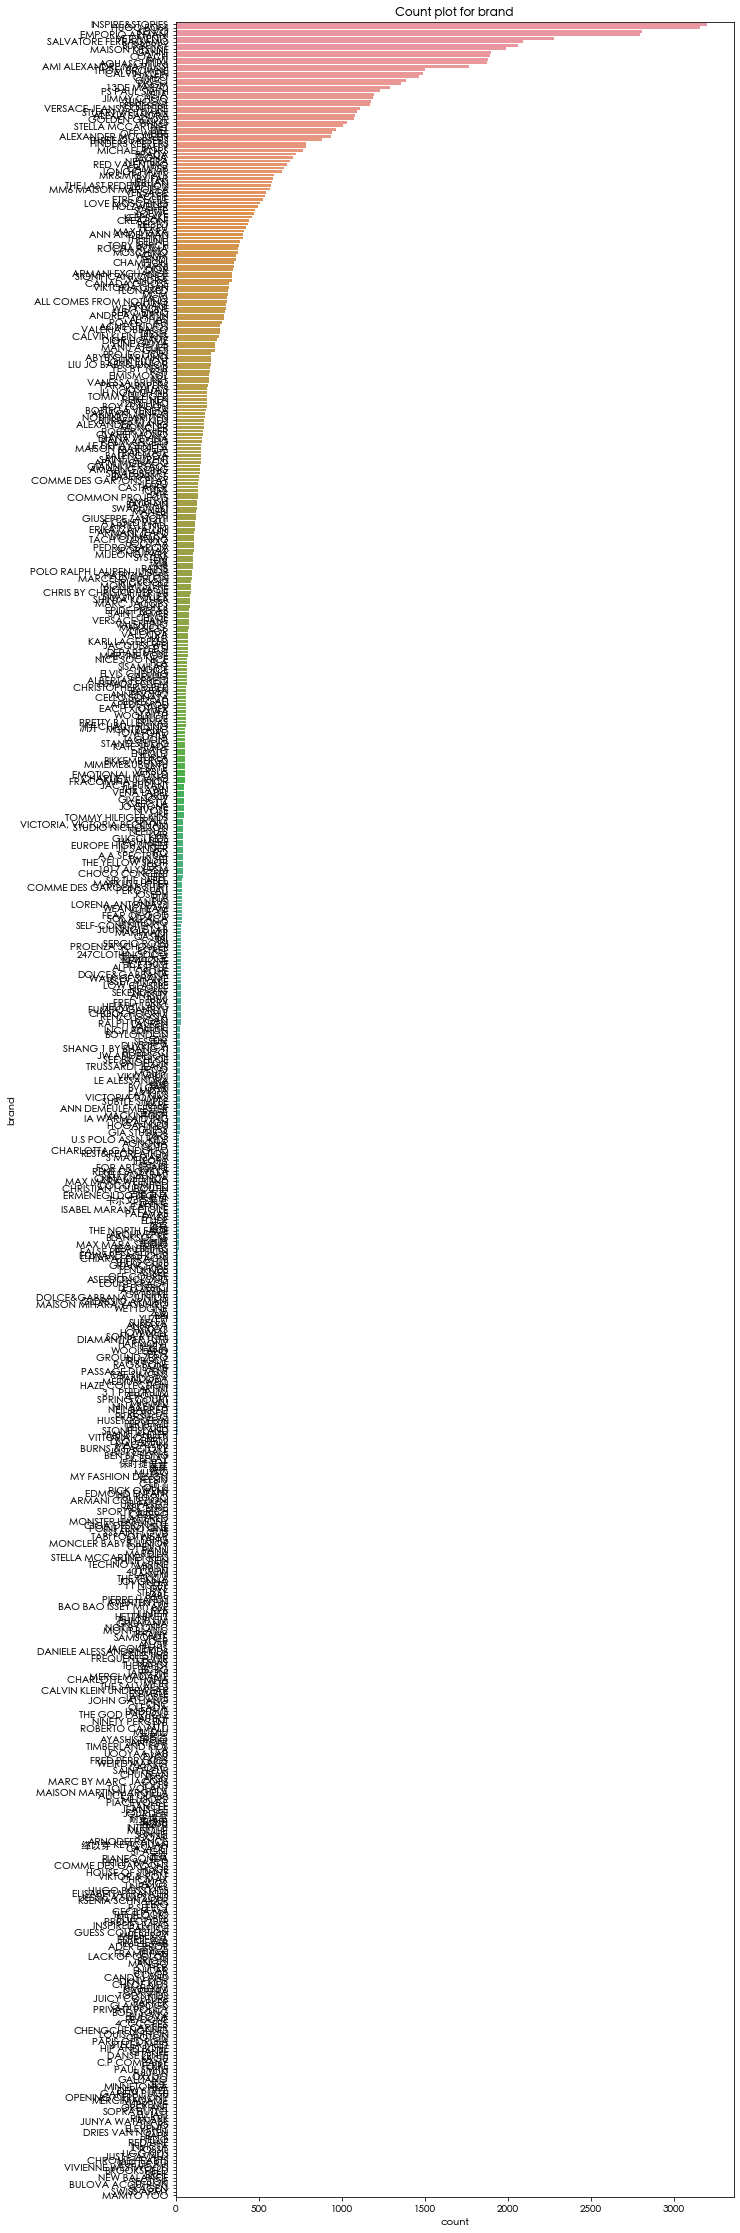

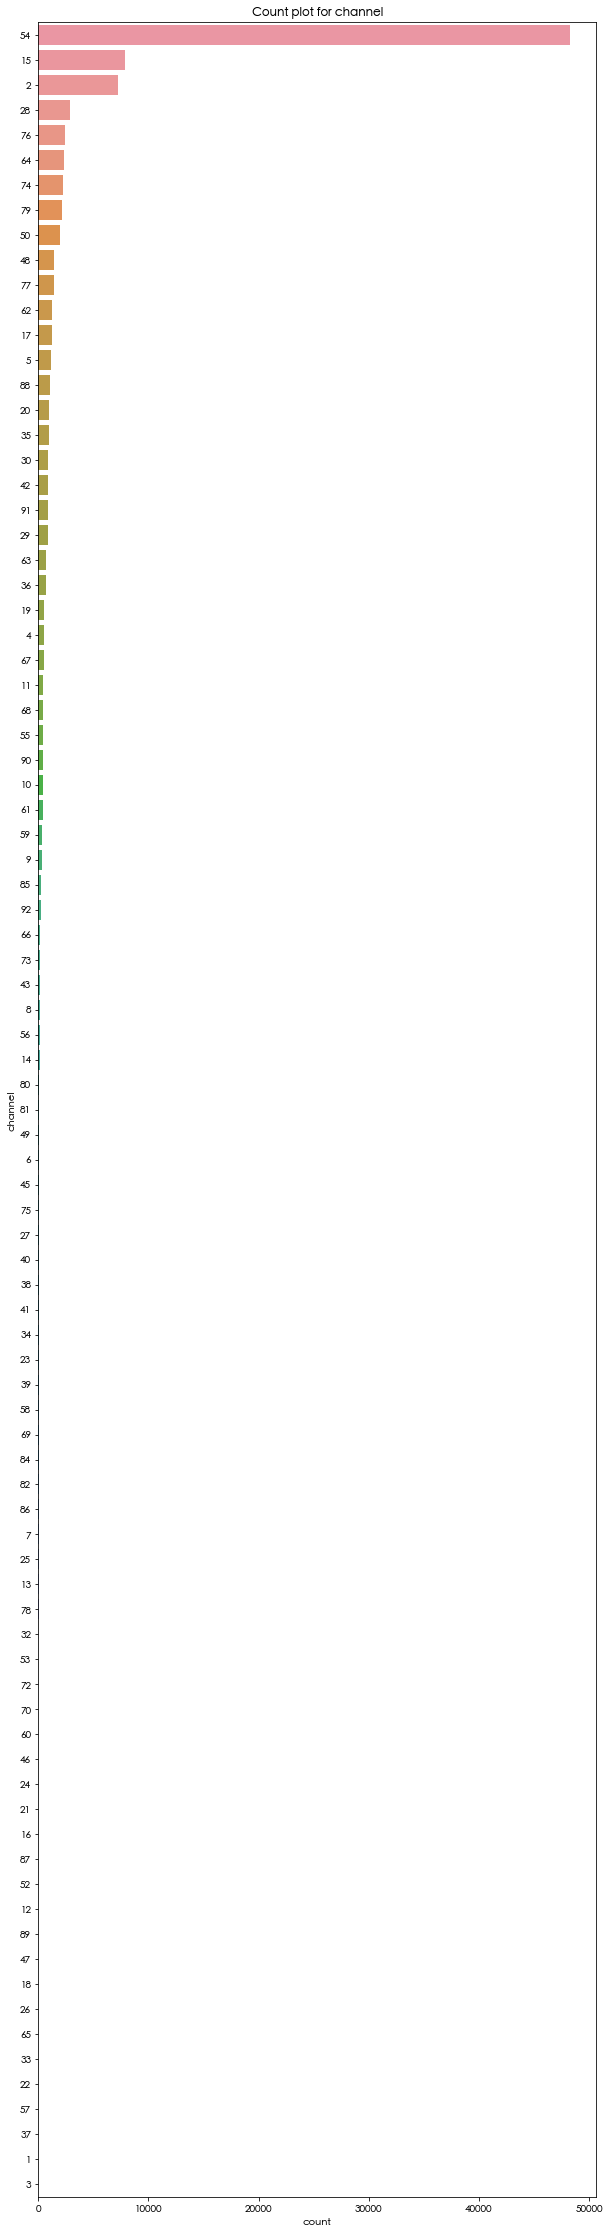

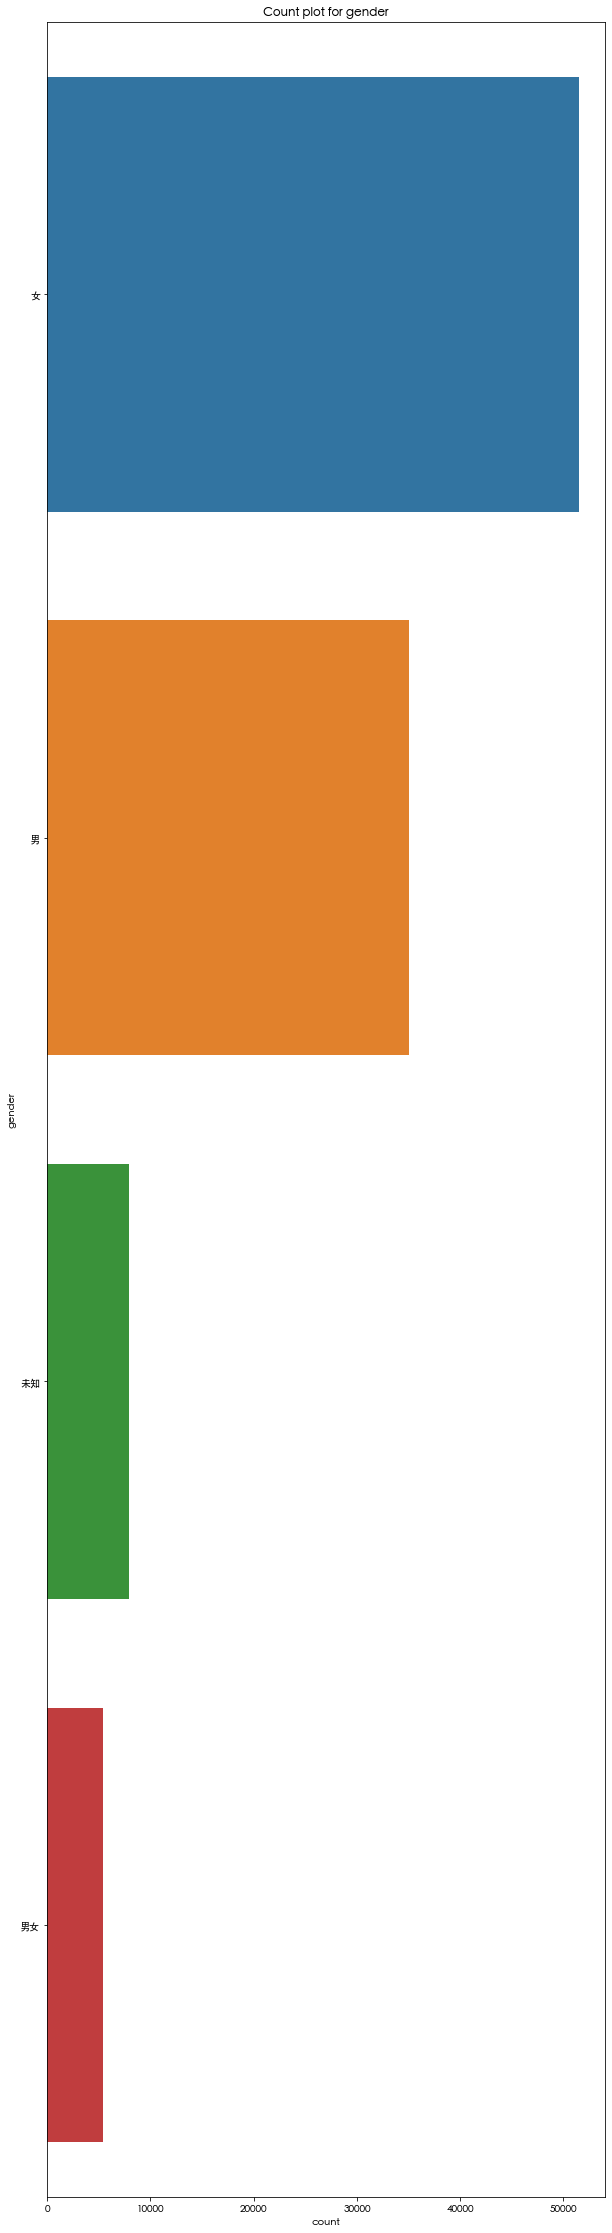

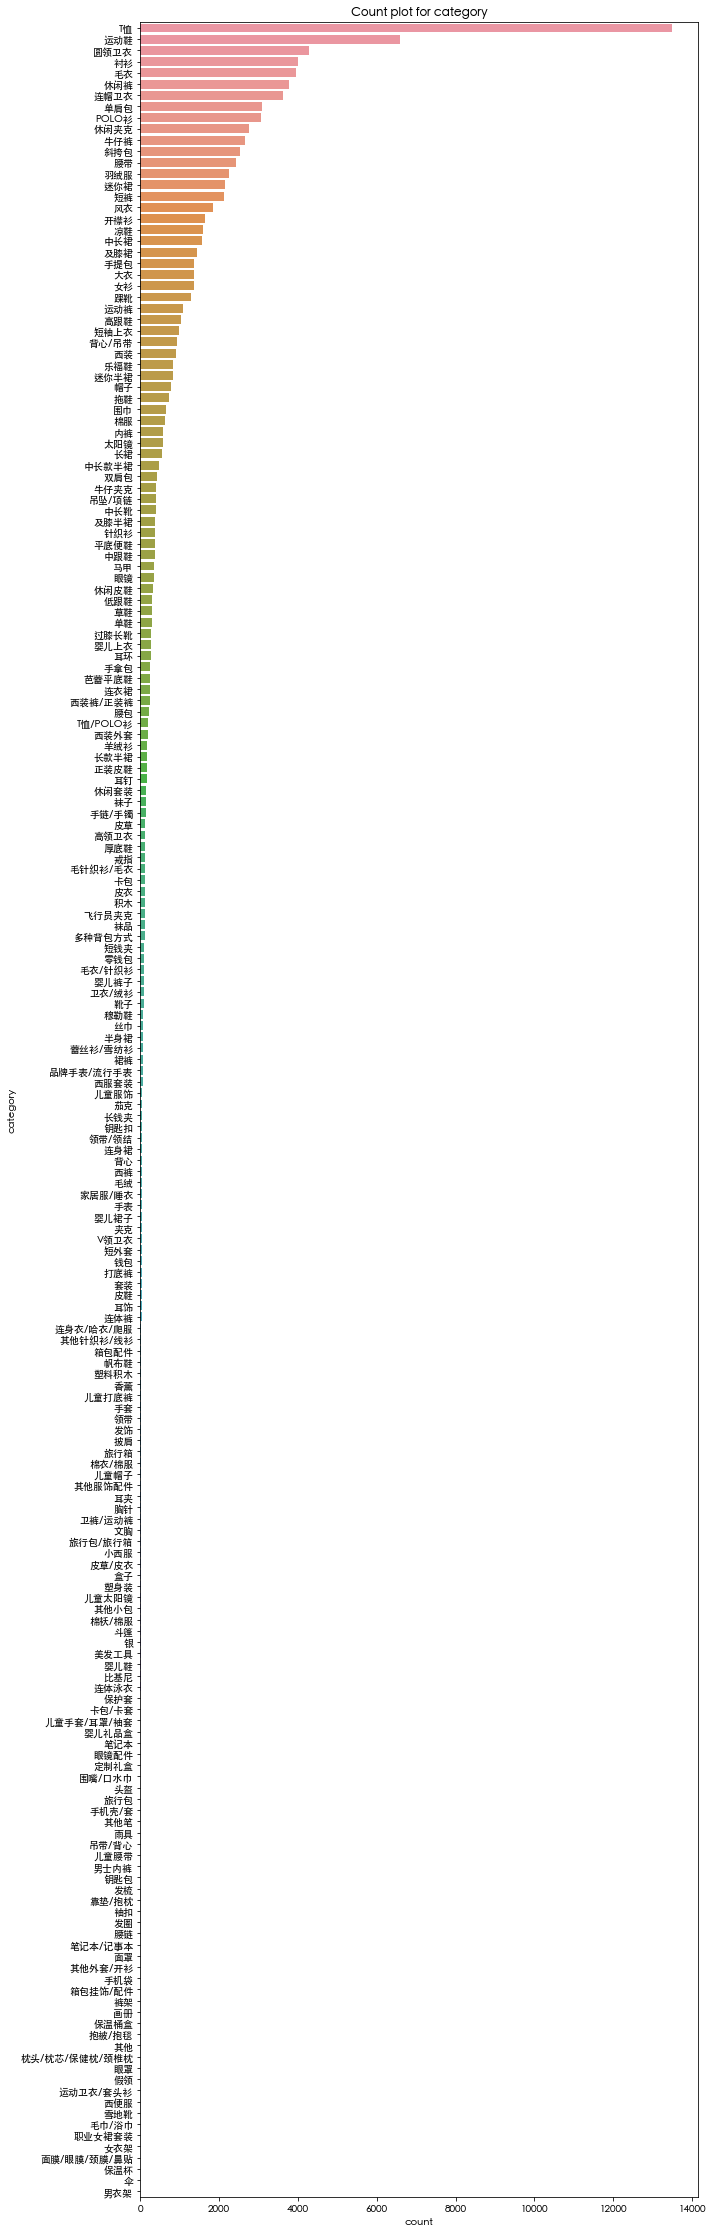

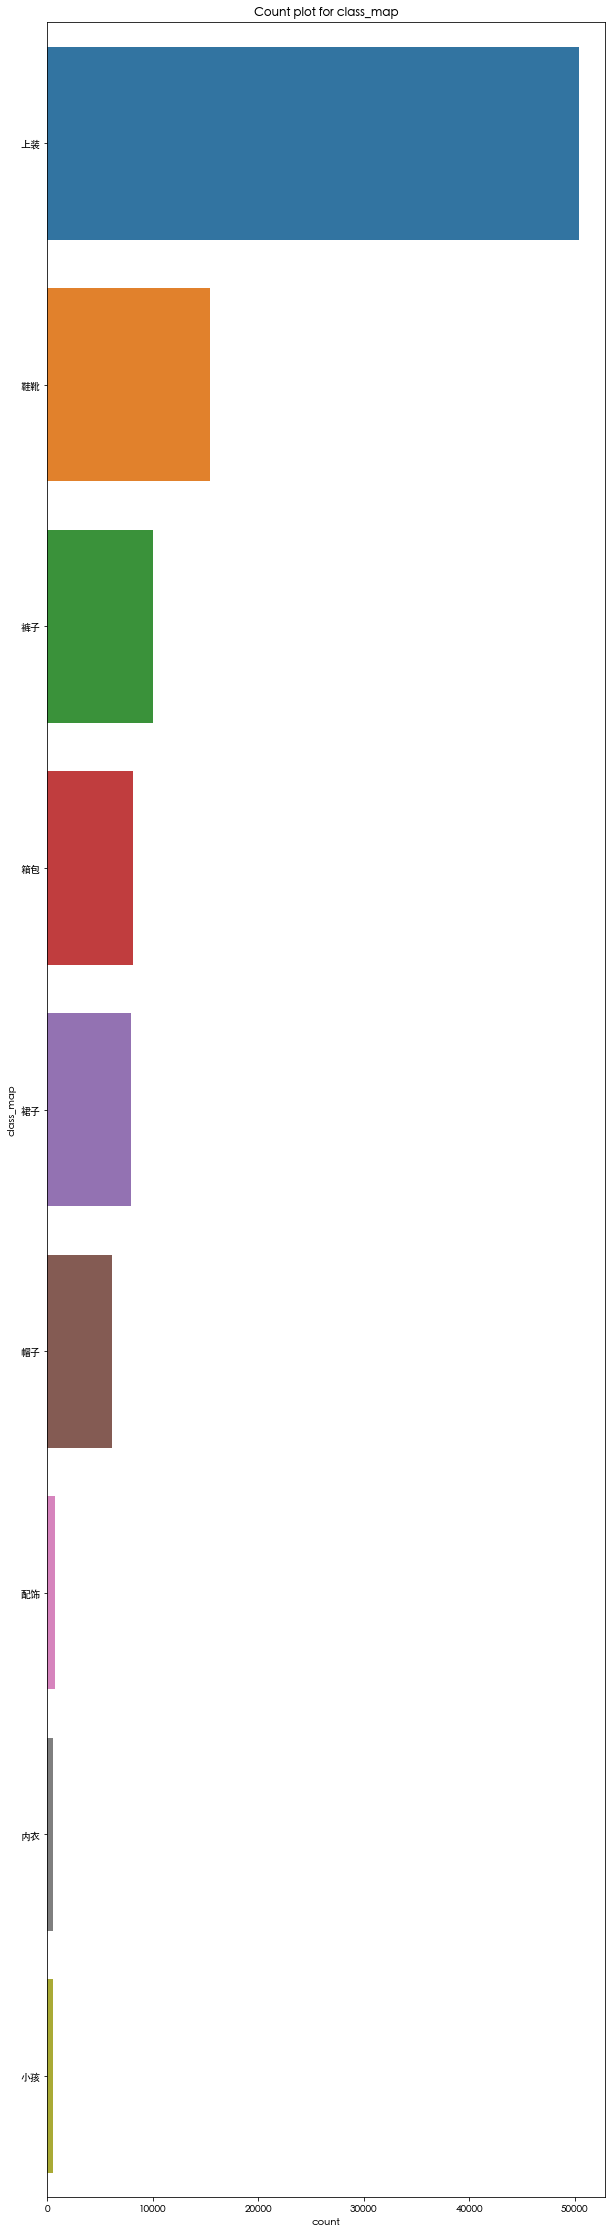

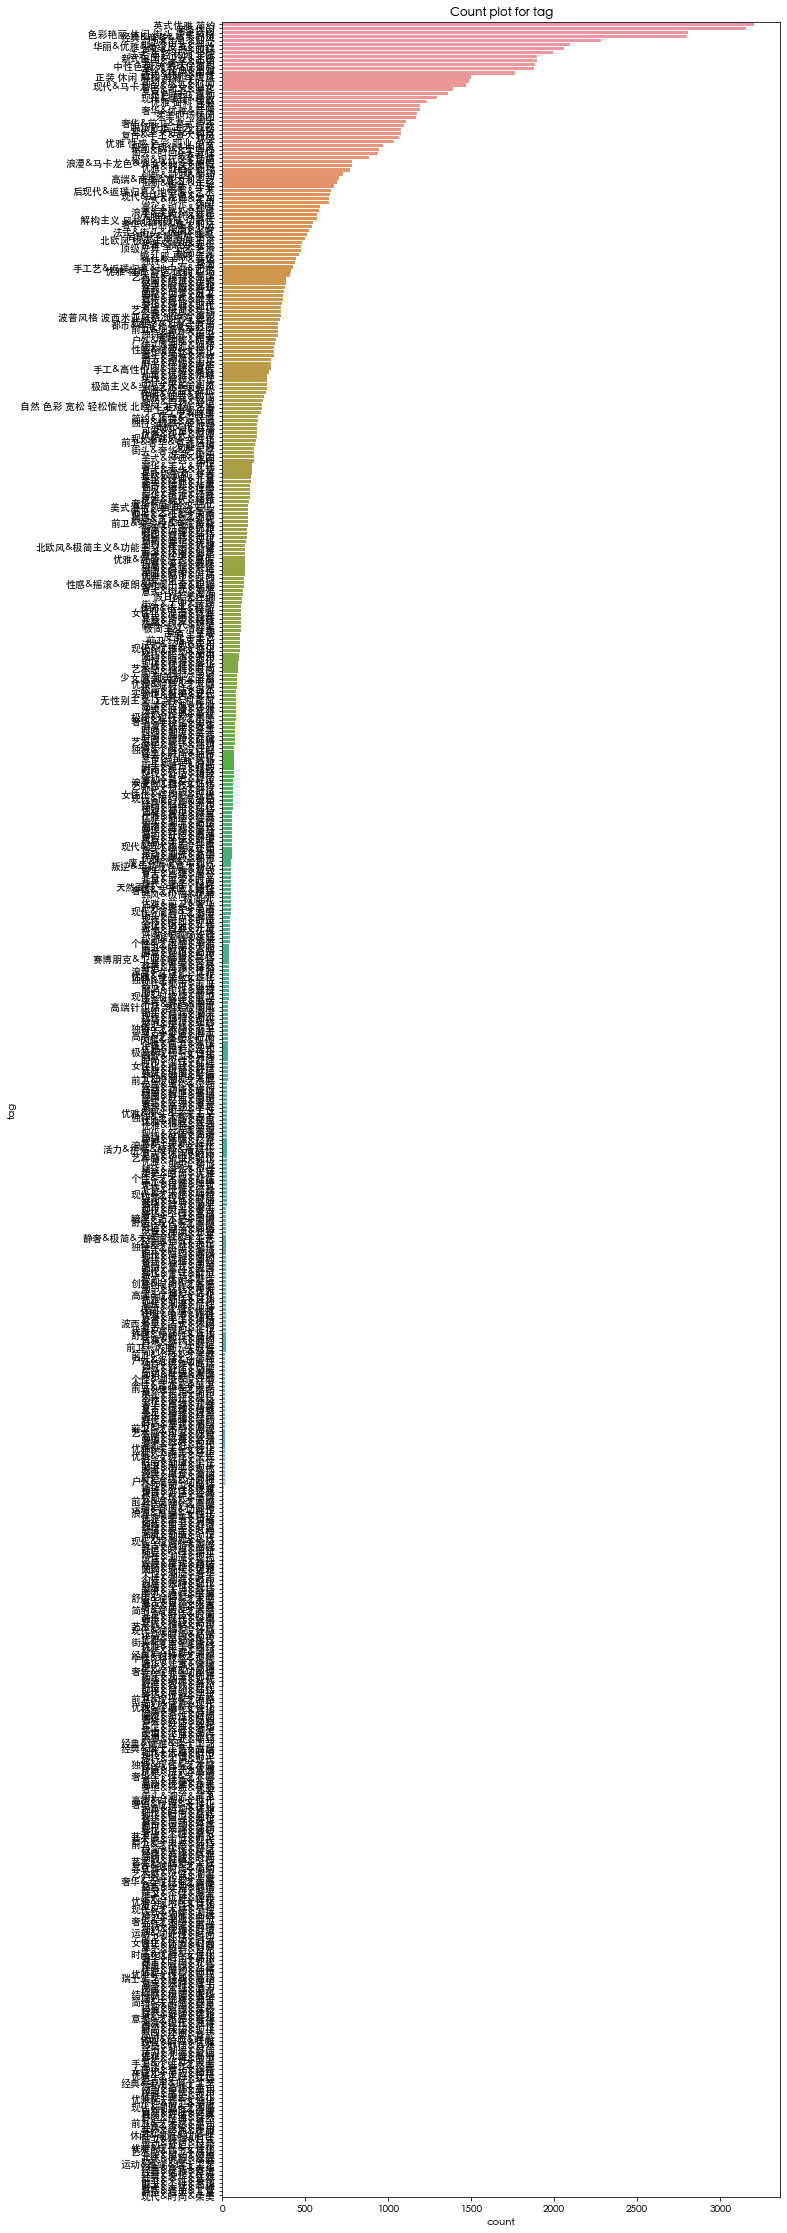

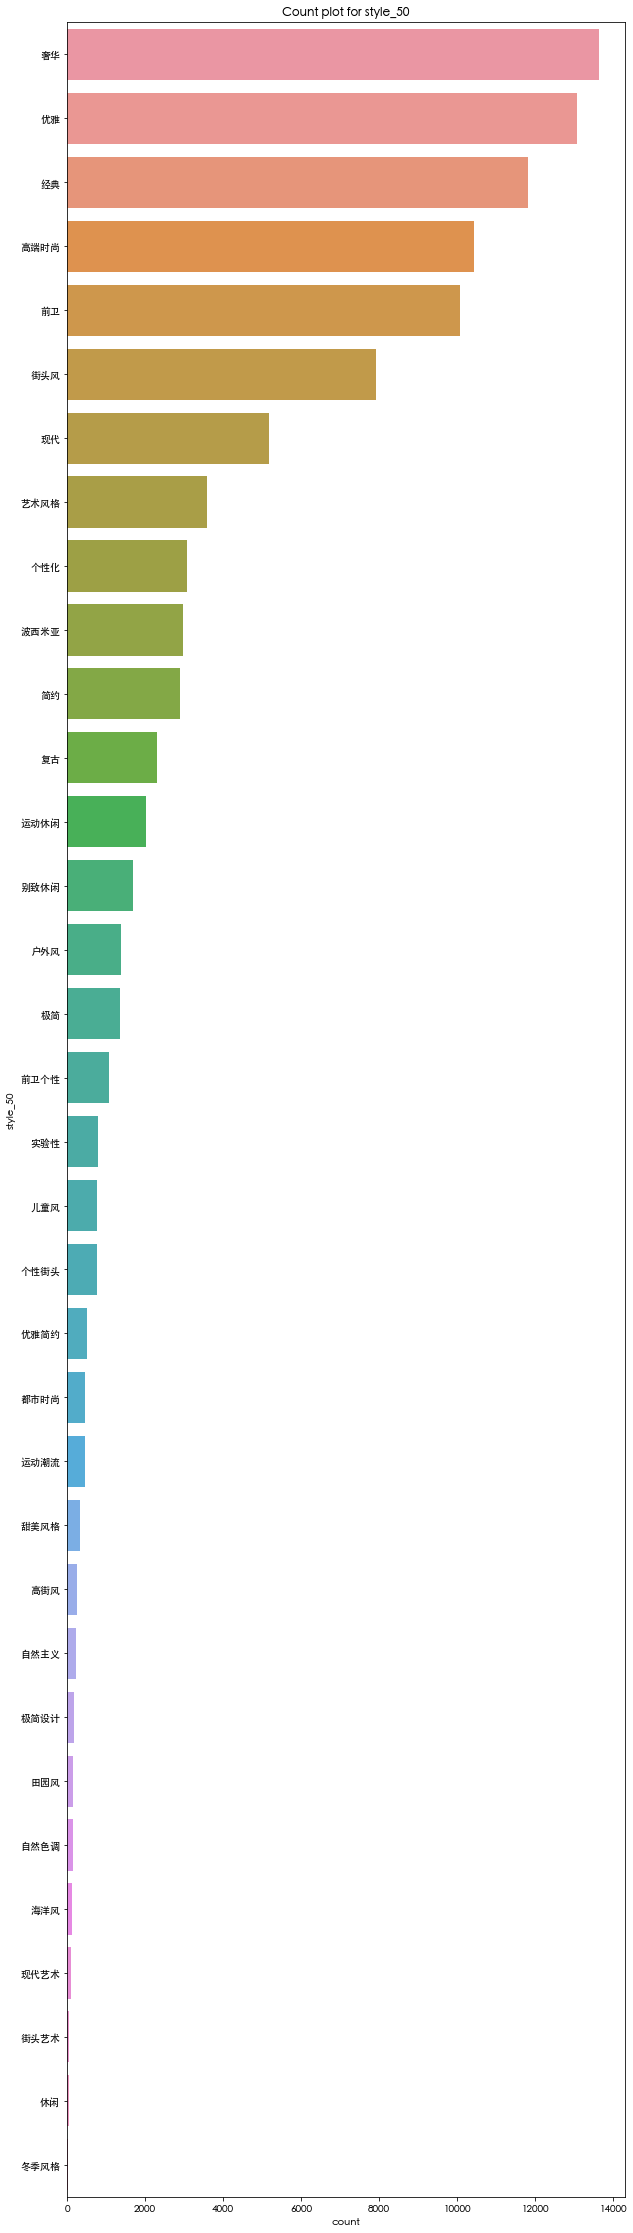

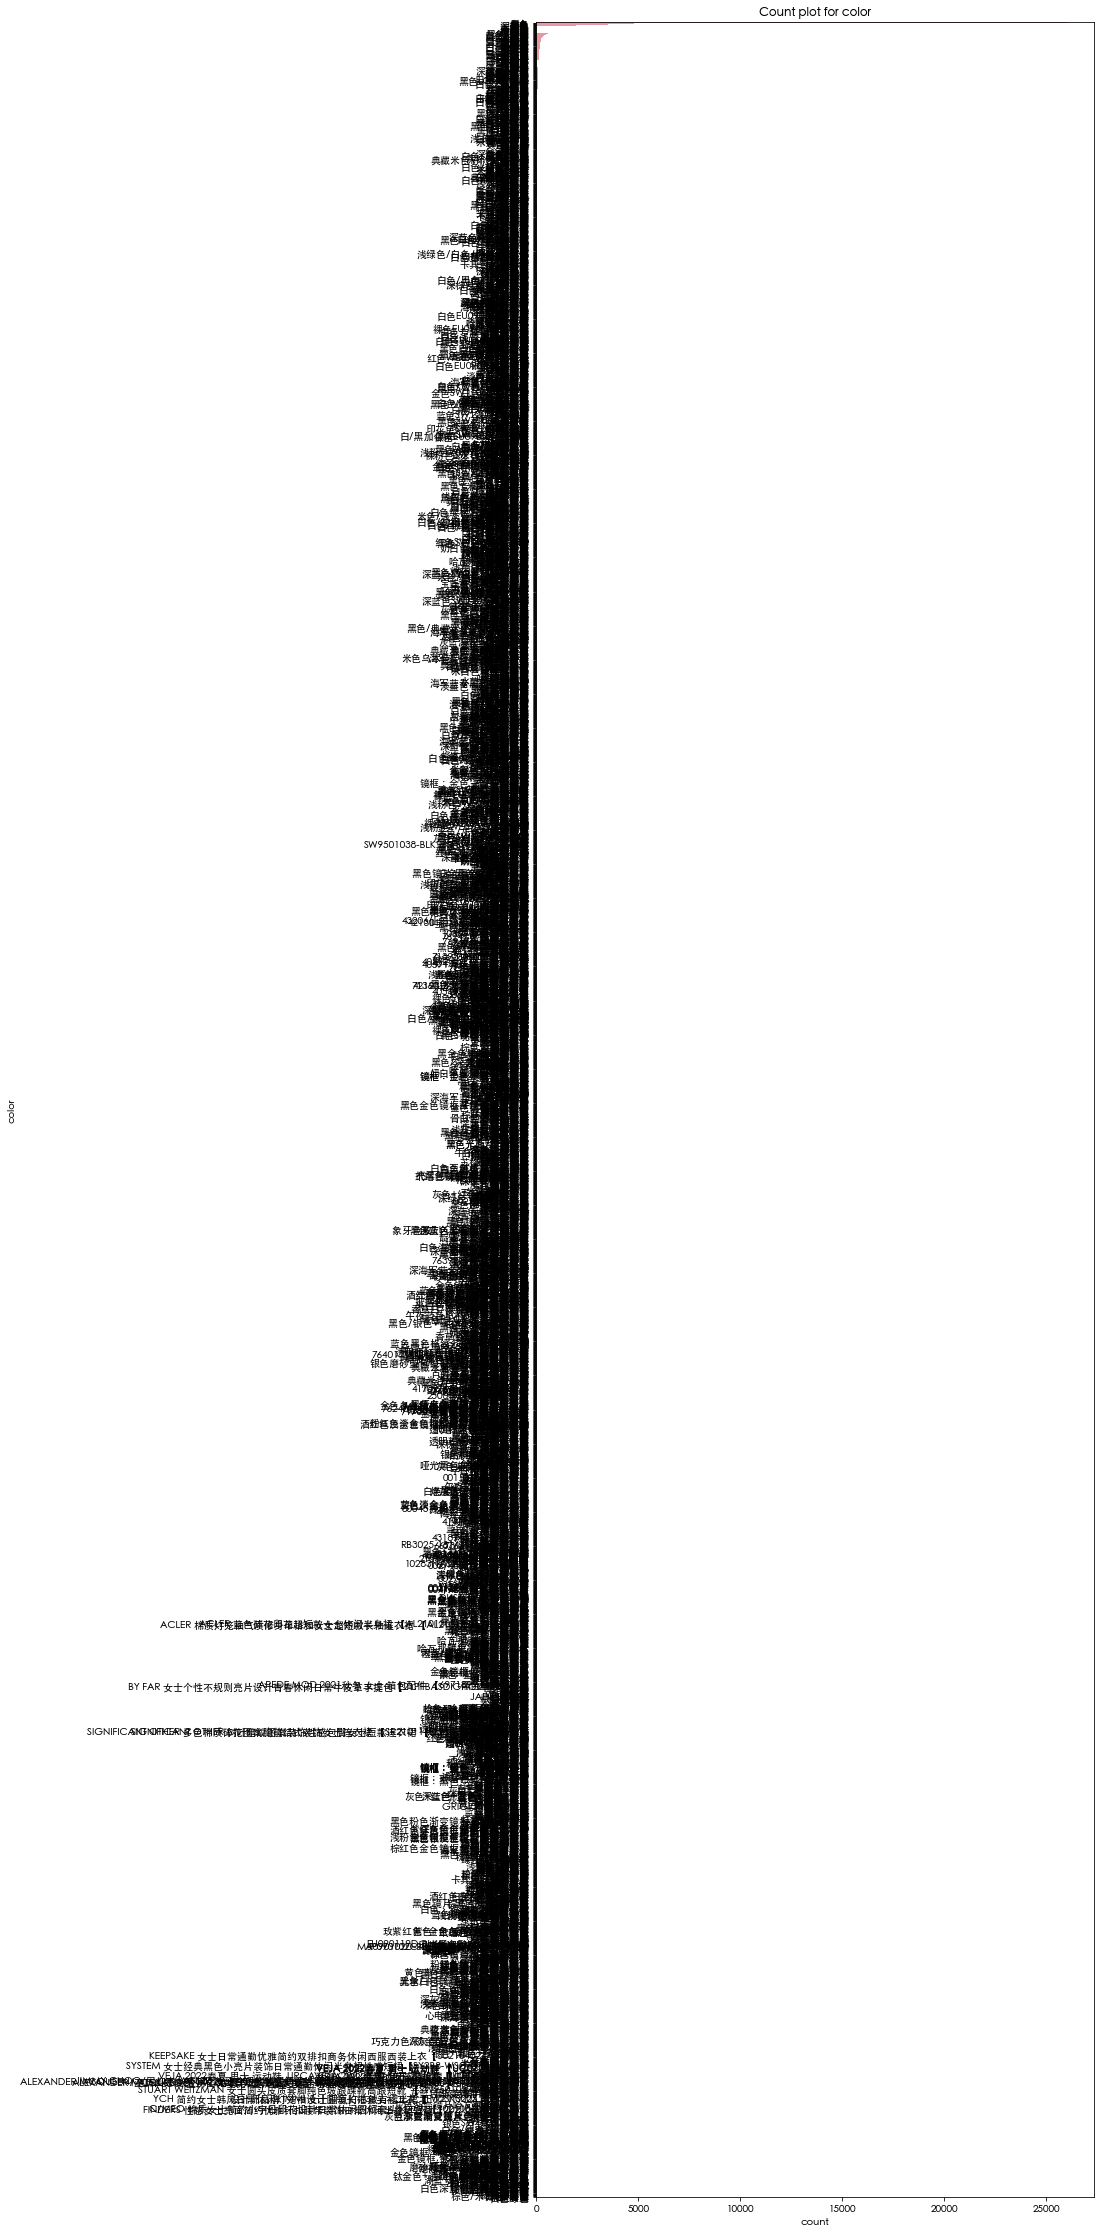

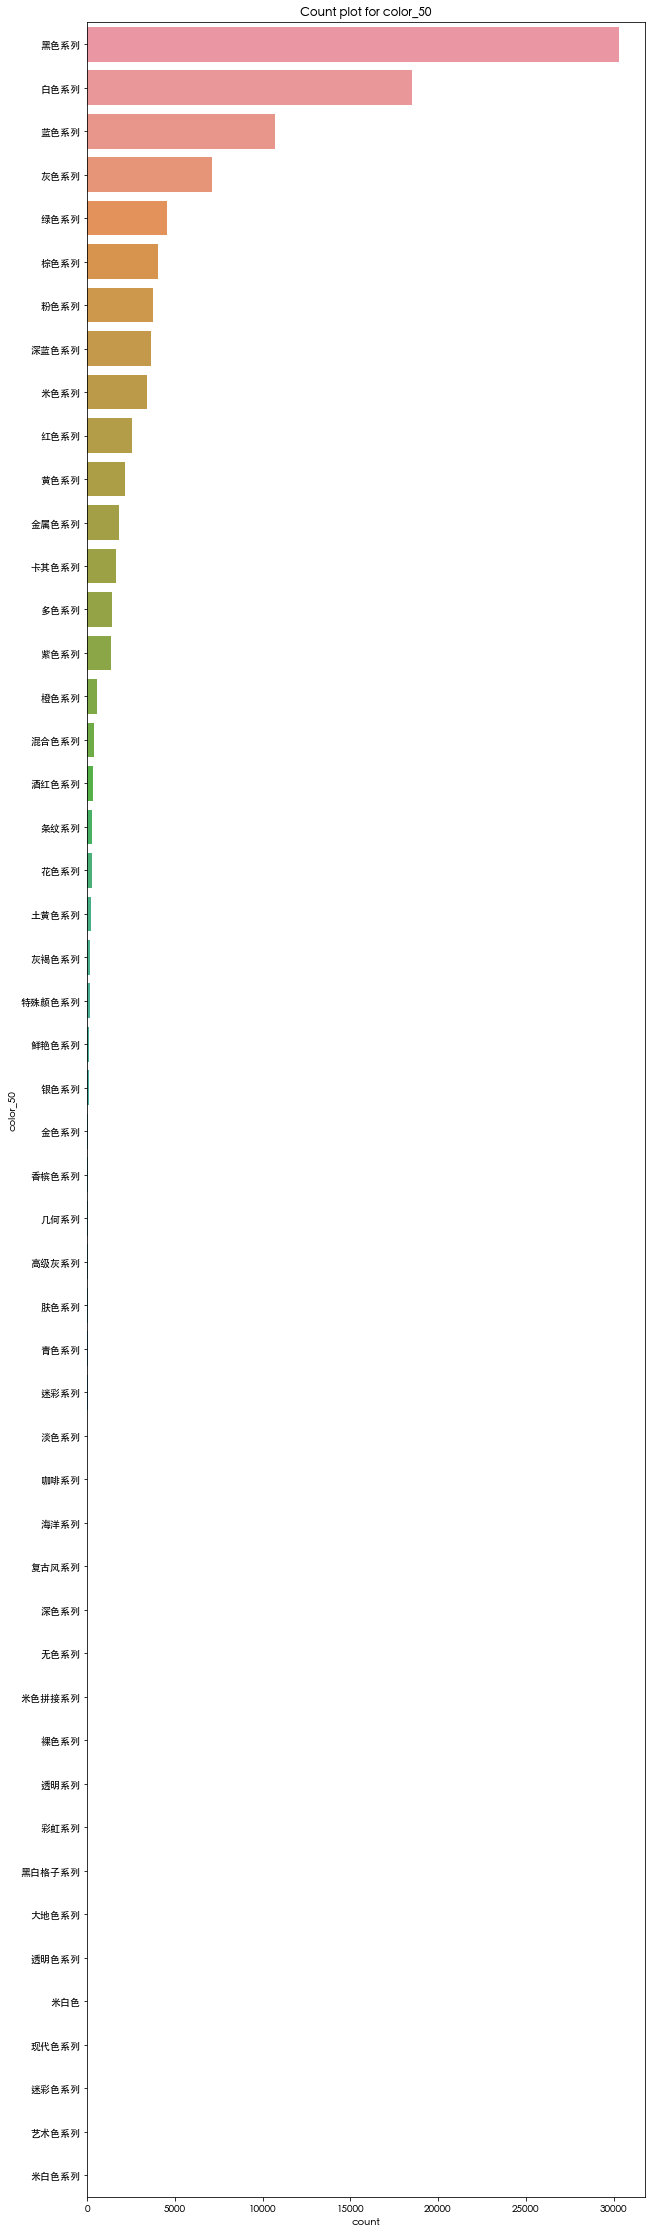

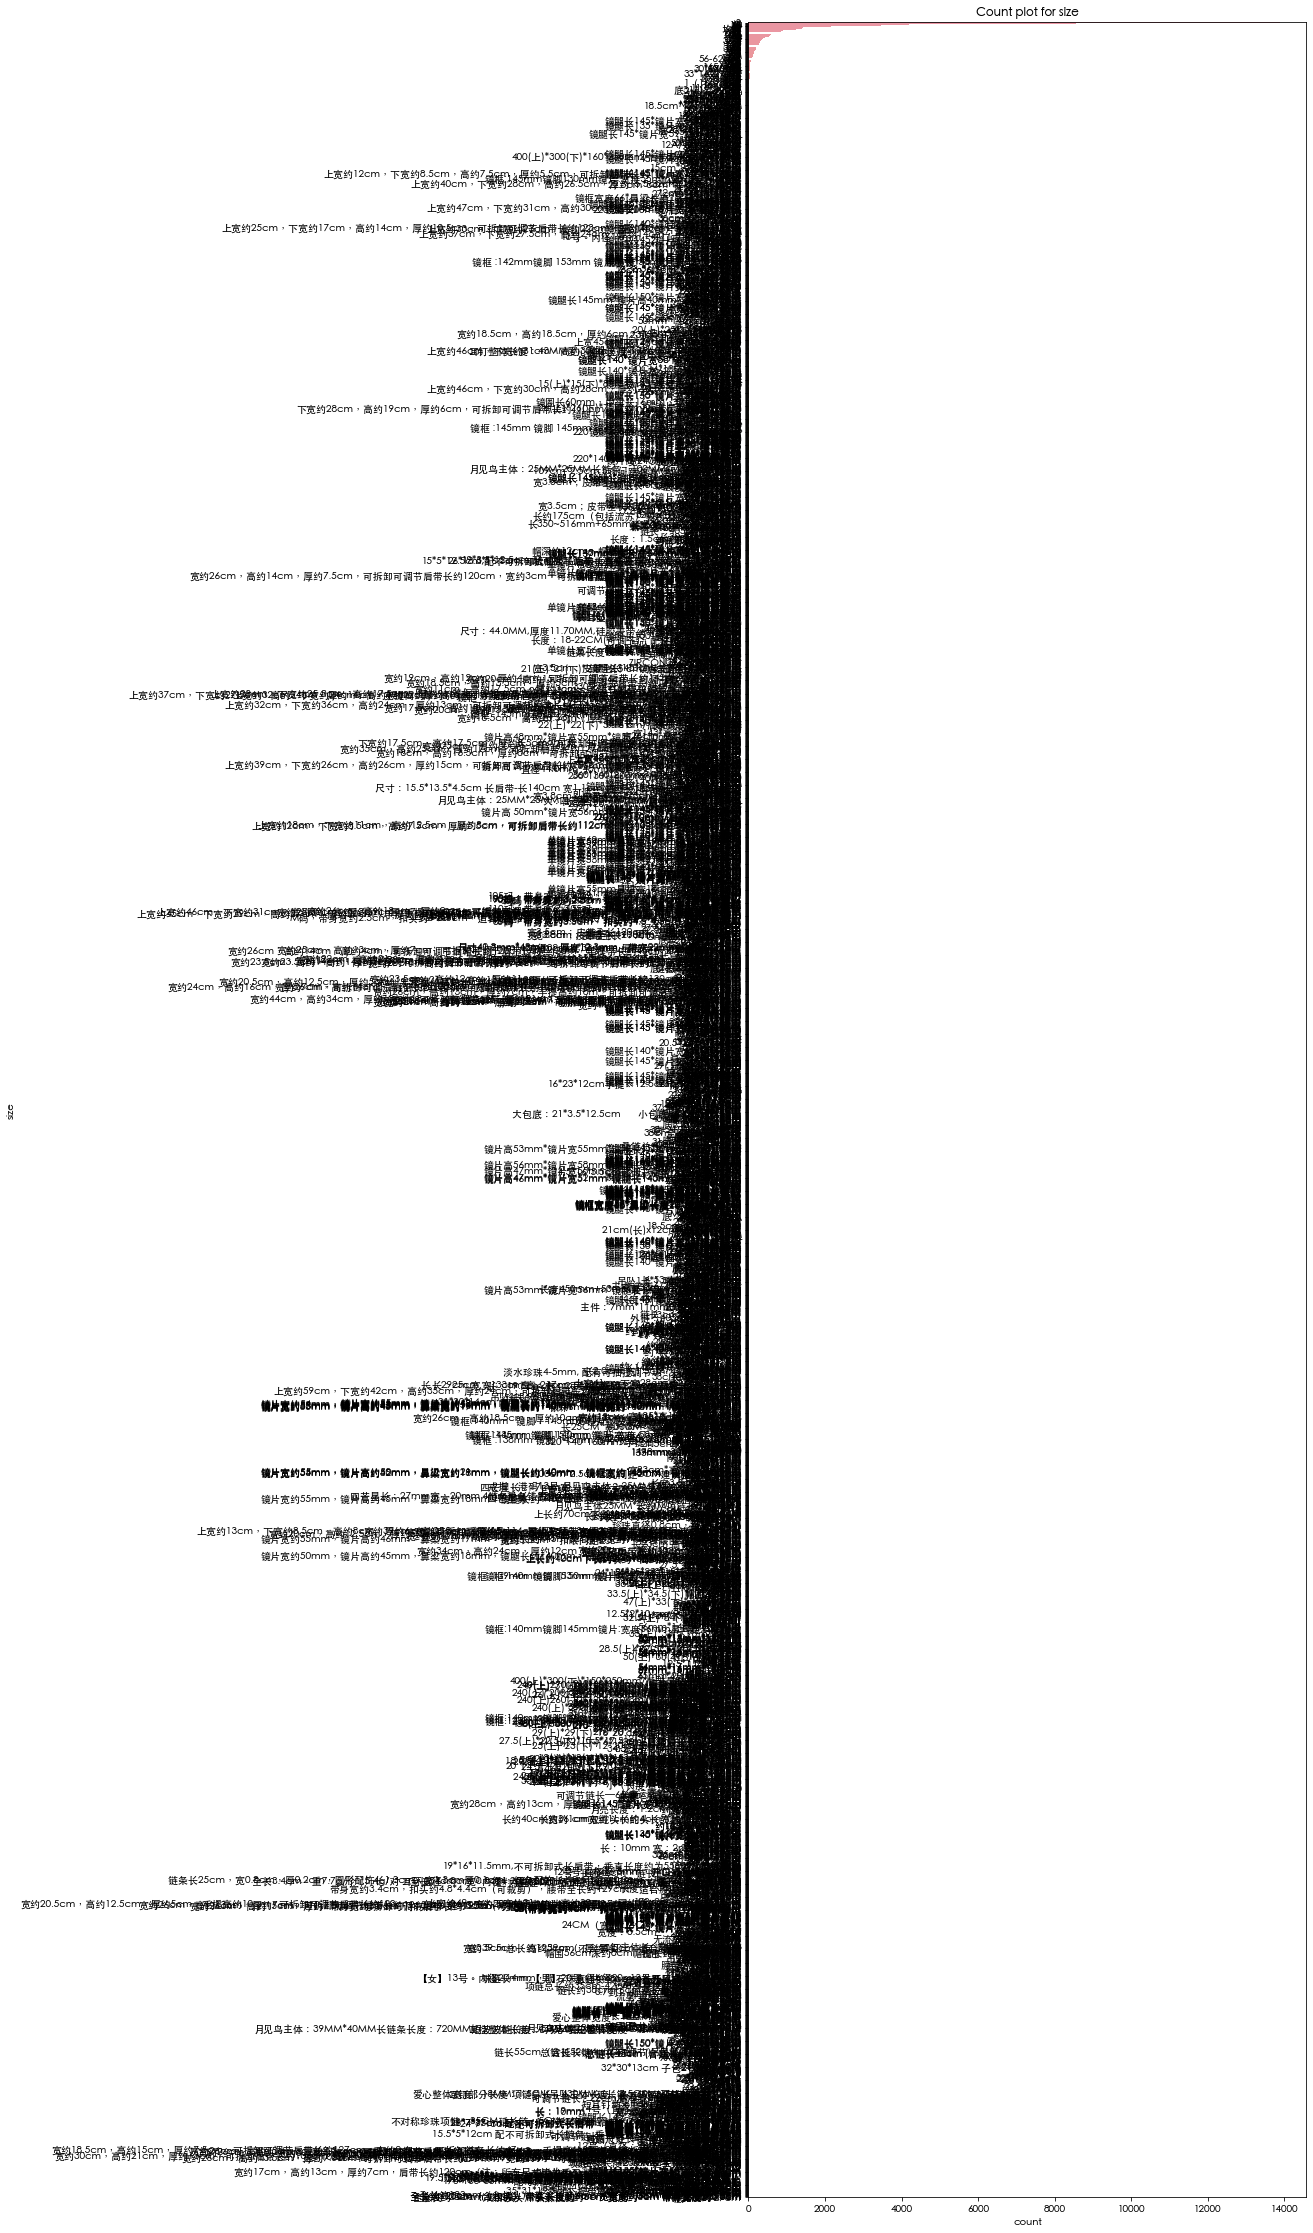

In [15]:

# count plot for the categorical variables 
columns_to_count = ['brand', 'channel','gender',  'category', 'class_map', 
                    'tag', 'style_50', 'color', 'color_50', 'size']
for col in columns_to_count:
    plt.figure(figsize=(10, 40))
    sns.countplot(y=col, 
                  data=train_items,
                  order=train_items[col].value_counts().index)
    plt.title(f'Count plot for {col}')
    plt.show()
    


In [16]:
# show the top10 items in columns_to_count and their corresponding counts
for col in columns_to_count:
    print(f"Top 10 items in {col}")
    print(train_items[col].value_counts().head(10))
    print("\n\n")

        


Top 10 items in brand
INSPIRE&STORIES        3200
HUGO BOSS              3156
KENZO                  2806
EMPORIO ARMANI         2799
VETEMENTS              2279
SALVATORE FERRAGAMO    2095
BURBERRY               2061
MAISON KITSUNE         1990
GANNI                  1897
COACH                  1896
Name: brand, dtype: int64



Top 10 items in channel
54    48218
15     7901
2      7215
28     2927
76     2405
64     2356
74     2294
79     2140
50     2013
48     1442
Name: channel, dtype: int64



Top 10 items in gender
女     51469
男     35076
未知     7929
男女     5419
Name: gender, dtype: int64



Top 10 items in category
T恤       13484
运动鞋       6577
圆领卫衣      4286
衬衫        3989
毛衣        3938
休闲裤       3774
连帽卫衣      3626
单肩包       3084
POLO衫     3066
休闲夹克      2751
Name: category, dtype: int64



Top 10 items in class_map
上装    50354
鞋靴    15418
裤子    10015
箱包     8169
裙子     7926
帽子     6125
配饰      767
内衣      595
小孩      524
Name: class_map, dtype: int64



Top 10 items in tag

In [17]:
# comparing the unique features of tag and style_50
# looks like there are overlaps between tag and style_50, use only style_50 in the model
train_items.tag.unique(), train_items.style_50.unique()


(array(['奢华&经典&现代', '高端&时尚&女性化', '潮流&个性&活力', '奢华&个性&前卫', '奢华&经典&高端',
        '优雅&女性化&奢华', '个性&前卫&独特', '奢华&意式&前卫', '时尚&意式&高端', '意式&奢华&经典',
        '现代&简约&舒适', '华丽&优雅&高级皮革&简约', '经典&奢华&高端', '女性化&休闲&时尚', '奢华&经典&优雅',
        '牛仔&叛逆&街头', '高端&奢华&经典', '经典&高端&英伦', '美式&时尚&潮流', '现代&时尚&优雅',
        '意式&休闲&时尚', '瑞士工艺&经典&高端', '奢华&经典&儿童', '环保&儿童&优雅', '极简&高端&优雅',
        '经典&瑞士工艺&高端', '简约&现代&时尚', '浪漫&优雅&奢华', '意式&经典&高端', '休闲&经典&现代',
        '个性&潮流&奢华', '意式&奢华&儿童', '英伦&经典&儿童', '儿童&优雅&经典', '可爱&儿童&时尚',
        '儿童&可爱&精致', '美式&经典&儿童', '户外&经典&儿童', '经典&高端&儿童', '奢华&儿童&保暖',
        '一线&哥特', '复古&前卫&奢华', '奢华&优雅&鞋履', '摇滚&性感&优雅', '优雅 材质 舒适 低调 职场',
        '时尚&都市&经典', '意式&优雅&儿童', '经典&高端&潮流', '优雅&前卫&奢华', '潮流&街头&个性',
        '经典&意式&高端', '艺术感&个性&现代', '舒适&自然&优雅', '个性&潮流&现代', '意式&独特&奢华',
        '创新&前卫&简约', '潮流&时尚&个性', '奢华&高端&经典', '经典&商务&意大利风', '前卫&创意&英伦风',
        '休闲&经典&时尚', '潮流&个性&现代', '前卫&潮流&独特', '经典&现代&实用', '极简&优雅&法式',
        '高端&商务&意大利工艺', '优雅 性感 色彩 职业 少女', '英伦&运动&职场', '高端&优雅&经典',
        '舒适&经典&儿童', '奢华&高端&儿童', 

### size feature analysis

In [18]:
# unique values of size.
# from the later modelling, size will be the most important feature, need to pay attention to it
train_items['size'].unique(), train_items['size'].nunique() # there are 4500+ sizes, too much, need spend time to do feature engineering

(array(['39', '30*26*22', '28*18*10 cm', ..., '24cm*13cm', '底23*14*22cm',
        '底29*19*27cm'], dtype=object),
 4515)

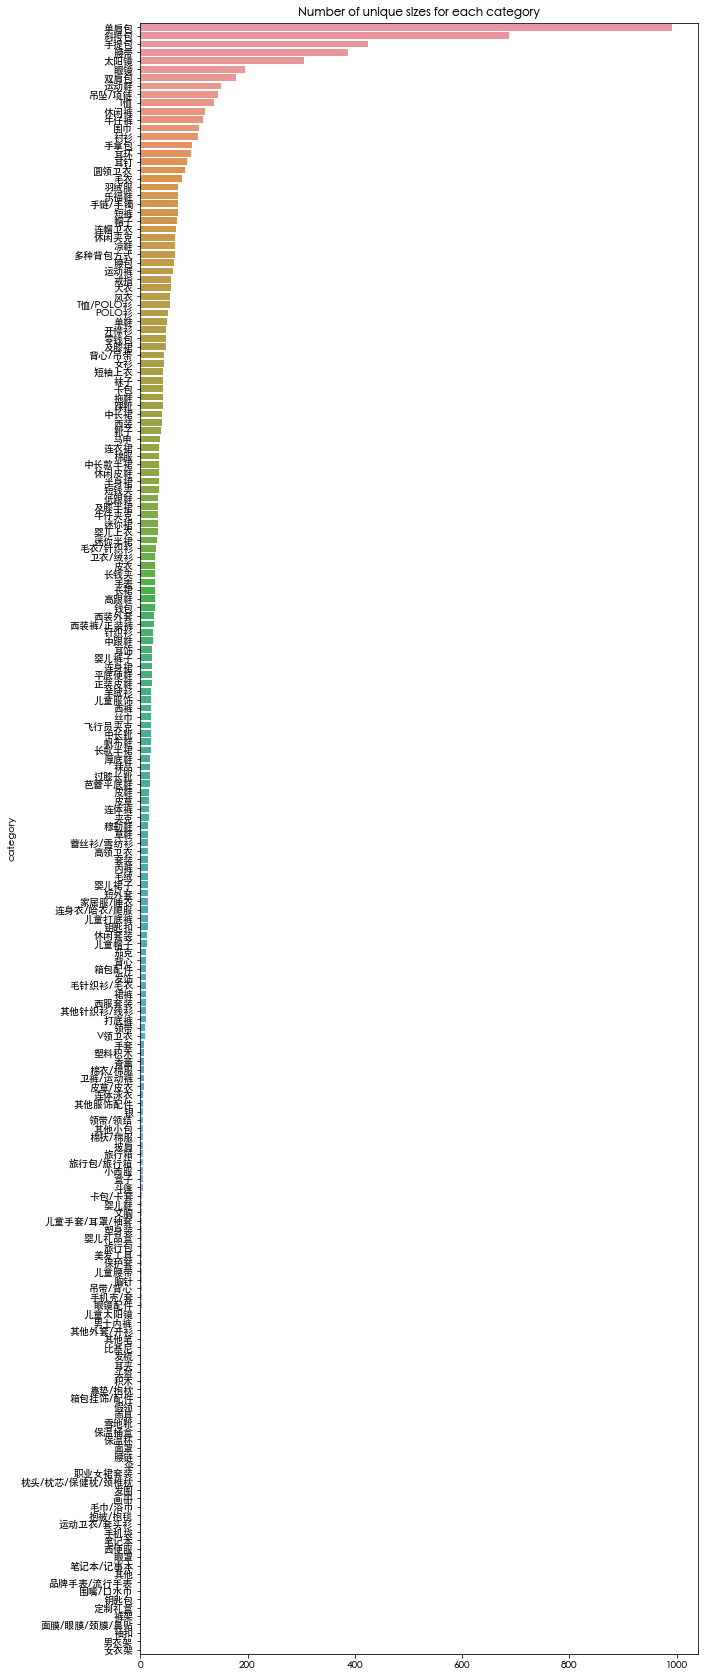

In [19]:
# show the top category that have multiple sizes.

# group by category, then count the unique values of size in each category
size_counts = train_items.groupby('category')['size'].nunique().sort_values(ascending=False)
# plot the size counts for each category
plt.figure(figsize=(10, 30))
sns.barplot(x=size_counts.values, y=size_counts.index)
plt.title('Number of unique sizes for each category')
plt.show()


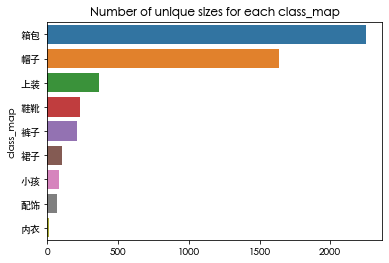

In [20]:
# grouped by class_map, then count the unique values of size in each class_map
size_counts = train_items.groupby('class_map')['size'].nunique().sort_values(ascending=False)
# plot the size counts for each class_map
# plt.figure(figsize=(10, 30))
sns.barplot(x=size_counts.values, y=size_counts.index)
plt.title('Number of unique sizes for each class_map')
plt.show()

# “箱包” “帽子” 的size数量太多，但实际上这些物品的size是不重要的，可以考虑将这些物品的size设置为U




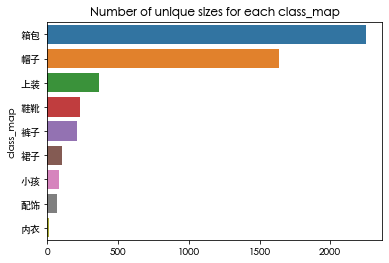

In [21]:
# grouped by class_map, then count the unique values of size in each class_map
size_counts = train_items.groupby('class_map')['size'].nunique().sort_values(ascending=False)
# plot the size counts for each class_map
# plt.figure(figsize=(10, 30))
sns.barplot(x=size_counts.values, y=size_counts.index)
plt.title('Number of unique sizes for each class_map')
plt.show()

# “箱包” “帽子” 的size数量太多，但实际上这些物品的size是不重要的，可以考虑将这些物品的size设置为U




In [22]:
# in class_map == '箱包', count the unique values of category
train_items[train_items['class_map'] == '箱包']['category'].value_counts()
# 这些箱包的category都是箱包，其实size是不重要的，对于这些箱包的每一类sub_category，将size设置为U


单肩包        3084
斜挎包        2523
手提包        1367
双肩包         428
手拿包         254
腰包          215
卡包          116
零钱包         100
长钱夹          52
旅行箱          13
旅行包/旅行箱       8
其他小包          6
旅行包           3
Name: category, dtype: int64

In [23]:
# in class_map == '帽子', count the unique values of category
train_items[train_items['class_map'] == '帽子']['category'].value_counts()
# 这些帽子的category都是帽子，其实size是不重要的，对于这些帽子的每一类sub_category，将size设置为U

腰带               2436
围巾                644
太阳镜               578
吊坠/项链             389
眼镜                344
耳环                266
耳钉                159
袜子                152
手链/手镯             139
戒指                121
积木                115
袜品                108
多种背包方式            106
丝巾                 72
品牌手表/流行手表          63
钥匙扣                46
领带/领结              45
手表                 37
钱包                 35
耳饰                 31
箱包配件               27
塑料积木               23
香薰                 20
手套                 17
领带                 17
披肩                 14
发饰                 14
其他服饰配件             12
耳夹                 10
胸针                  9
盒子                  6
美发工具                5
银                   5
卡包/卡套               4
笔记本                 4
保护套                 4
手机壳/套               3
其他笔                 3
雨具                  3
定制礼盒                3
头盔                  3
眼镜配件                3
发梳                  2
袖扣                  2
靠垫/抱枕               2
笔记本/记事本   

In [24]:
# in class_map == '配饰', count the unique values of category
# 配饰 其实是'帽子', size也不重要. 
train_items[train_items['class_map'] == '配饰']['category'].value_counts()


帽子    767
Name: category, dtype: int64

In [25]:
# size value counts for class_map == '上装'
train_items[train_items['class_map'] == '上装']['size'].nunique(), train_items[train_items['class_map'] == '上装']['size'].value_counts()


(365,
 S                        10779
 M                        10659
 L                         7027
 XS                        4815
 XL                        3640
 XXL                        999
 38                         943
 40                         731
 36                         731
 1                          623
 2                          532
 34                         501
 XXS                        499
 48                         448
 50                         430
 001                        413
 42                         373
 000                        370
 2XL                        358
 4                          343
 3                          338
 0                          314
 46                         313
 52                         302
 U                          225
 3XL                        223
 F                          215
 002                        202
 54                         144
 32                         141
 T2                         130
 3

In [26]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', None)
# for those 上装, group by country_size, show the unique values of size. shoe all possible values
size_table = train_items[train_items['class_map'] == '上装'].groupby('country_size')['size'].unique()
# show all table content
pd.set_option('display.max_rows', None)
(size_table)

country_size
0/1/2/3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [S, XS, M, L]
00/0/1/2(STUDIO NICHOLSON)/常规码                                                                                                                                                                                                                                                                                                                                                                                                           

 ### Price range and price

 Looks like there is no relationship between price and rating. 

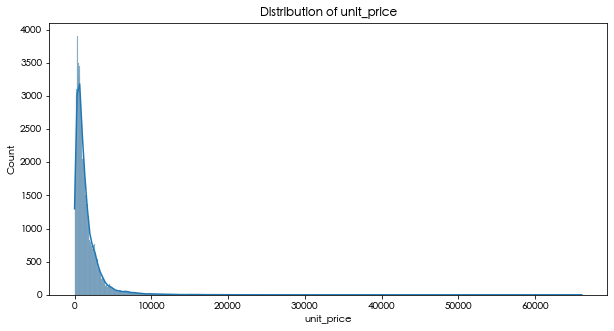

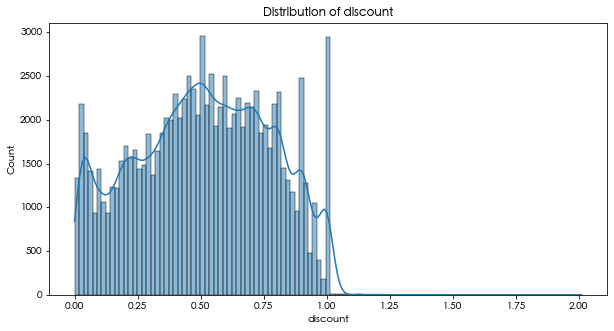

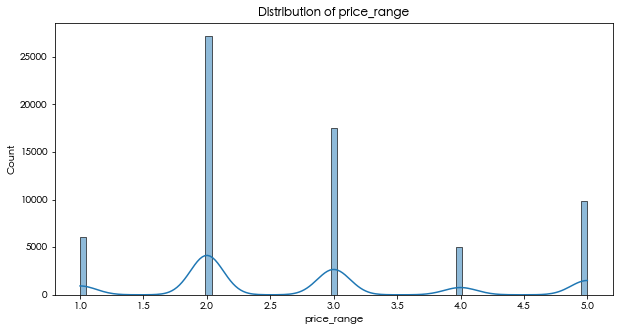

In [27]:
# distribution of the numerical variables
columns_to_plot = ['unit_price', 'discount',  'price_range']
for col in columns_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_items[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


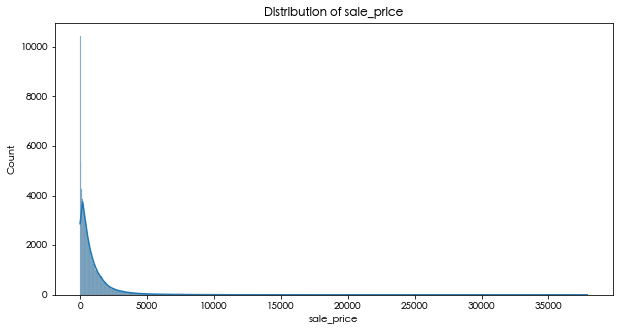

In [28]:
# sale_price = unit_price * discount, draw distribution of sale_price
train_items['sale_price'] = train_items['unit_price'] * train_items['discount']
plt.figure(figsize=(10, 5))
sns.histplot(train_items['sale_price'], kde=True)
plt.title('Distribution of sale_price')
plt.show()

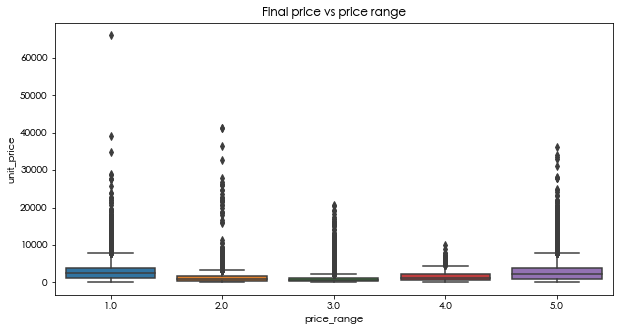

In [29]:
# plot final_price = price*discount vs price range
train_items['final_price'] = train_items.unit_price * train_items.discount
plt.figure(figsize=(10, 5))
sns.boxplot(x='price_range', y='unit_price', data=train_items)
plt.title('Final price vs price range')
plt.show()


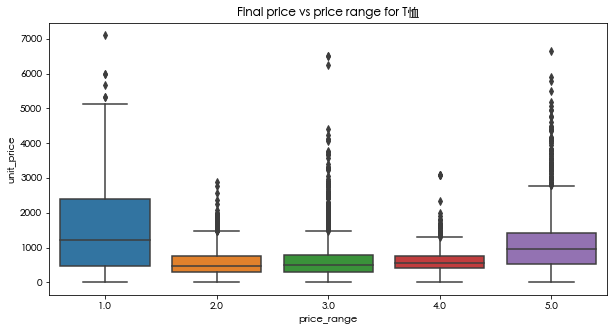

In [30]:
# plot final_price vs price range for each category=="T恤"
plt.figure(figsize=(10, 5))
sns.boxplot(x='price_range', y='unit_price', data=train_items[train_items.category=='T恤'])
plt.title('Final price vs price range for T恤')
plt.show()



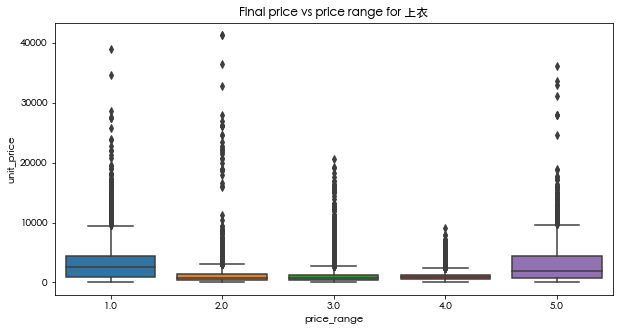

In [31]:
# plot final_price vs price range for category_map=="上衣"
plt.figure(figsize=(10, 5))
sns.boxplot(x='price_range', y='unit_price', data=train_items[train_items.class_map=='上装'])
plt.title('Final price vs price range for 上衣')
plt.show()


## 1.3 Interactions

In [7]:
# load interactions
train_interactions = pd.read_csv("train_interactions.csv")
train_interactions.head()

user_id  item_ID  order_time
0   209227  1595587  2024-03-14
1   243637  1639001  2024-03-14
2   265503  1675222  2024-03-14
3   183614  1662640  2024-03-14
4   188753  1662540  2024-03-14

# 2. Featurization

## 2.1 Item Features

Some features have multiple values, which is too much for one-hot encoding. I do the feature engineering to reduce the number of values.

### Brand feature engineering

In [8]:
# for brand, changed the counts that less than 300 to 'others'
brand_counts = train_items.brand.value_counts()
train_items['brand'] = train_items['brand'].apply(lambda x: 'others' if brand_counts[x] < 300 else x)
train_items['brand'].value_counts()


others                     22916
INSPIRE&STORIES             3200
HUGO BOSS                   3156
KENZO                       2806
EMPORIO ARMANI              2799
VETEMENTS                   2279
SALVATORE FERRAGAMO         2095
BURBERRY                    2061
MAISON KITSUNE              1990
GANNI                       1897
COACH                       1896
IMMI                        1882
AQUASCUTUM                  1877
AMI ALEXANDRE MATTIUSSI     1765
THOM BROWNE                 1499
CALVIN KLEIN                1487
C/MEO                       1467
GUCCI                       1388
MSGM                        1357
13DE MARZO                  1291
PS PAUL SMITH               1231
VEJA                        1194
JIMMY CHOO                  1191
SUNCOO                      1174
REPRESENT                   1169
VERSACE JEANS COUTURE       1109
STUART WEITZMAN             1094
ALEXIA SANDRA               1078
GOLDEN GOOSE                1077
PINKO                       1035
STELLA MCC

In [21]:
# apply the brand classification to the test data as well
test_items['brand'] = test_items['brand'].apply(
    lambda x: 'others' if x not in brand_counts or brand_counts[x] < 300 else x)


In [22]:
# check the brand values in test all appear in train
test_items[~test_items['brand'].isin(train_items['brand'])].shape # all the brand values in test appear in train

(0, 24)

### channel feature engineering

In [9]:
# for channel, changed to str, and only keep channel 54, 15, 2, others as 'others'
train_items['channel'] = train_items['channel'].astype(str)
train_items['channel'] = train_items['channel'].apply(
    lambda x: x if x in ['54', '15', '2'] else 'others')
train_items['channel'].value_counts()


54        48218
others    36559
15         7901
2          7215
Name: channel, dtype: int64

In [10]:
# do the same for test items
test_items['channel'] = test_items['channel'].astype(str)
test_items['channel'] = test_items['channel'].apply(
    lambda x: x if x in ['54', '15', '2'] else 'others')
test_items['channel'].value_counts()


others    5888
54        4033
2         1462
15         127
Name: channel, dtype: int64

### sale price feature engineering

As there is discount for some items, we can create a new feature called sale price.

In [11]:
# sale price = unit price * discount
train_items['sale_price'] = train_items['unit_price'] * train_items['discount']
test_items['sale_price'] = test_items['unit_price'] * test_items['discount']

### size feature engineering

In [12]:
# change the size of class_map == '配饰' and '帽子'  and '箱包' to 'U'
train_items.loc[train_items['class_map'] == '配饰', 'size'] = 'U'
train_items.loc[train_items['class_map'] == '帽子', 'size'] = 'U'
train_items.loc[train_items['class_map'] == '箱包', 'size'] = 'U'
# change the size == '均码' to 'U'
train_items.loc[train_items['size'] == '均码', 'size'] = 'U'
# do the same for test items
test_items.loc[test_items['class_map'] == '配饰', 'size'] = 'U'
test_items.loc[test_items['class_map'] == '帽子', 'size'] = 'U'
test_items.loc[test_items['class_map'] == '箱包', 'size'] = 'U'
# change the size == '均码' to 'U'
test_items.loc[test_items['size'] == '均码', 'size'] = 'U'


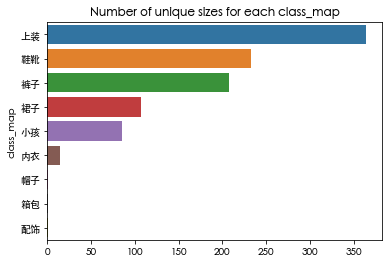

In [13]:
# grouped by class_map, then count the unique values of size in each class_map
size_counts = train_items.groupby('class_map')['size'].nunique().sort_values(ascending=False)
# plot the size counts for each class_map
# plt.figure(figsize=(10, 30))
sns.barplot(x=size_counts.values, y=size_counts.index)
plt.title('Number of unique sizes for each class_map')
plt.show()

### selected features for items and fill na

In [14]:
item_feature = ['item_ID', 'item_name', 'brand', 'channel', 
       'size',  'gender', 'class_map', 
       'price_range', 
       'style_50', 'color_50', "unit_price", "discount",'sale_price']
train_items_feature = train_items[item_feature]
test_items_feature = test_items[item_feature]

### Missing value imputation.

In [15]:
# fill na of size with 'U', fill na of color_50 with 'others', fill na of discount with 1, then recalcuate sale_price
train_items_feature['size'] = train_items_feature['size'].fillna('U')
train_items_feature['color_50'] = train_items_feature['color_50'].fillna('others')
train_items_feature['discount'] = train_items_feature['discount'].fillna(1)
# fill na of price_range with most frequent value
train_items_feature['price_range'] = train_items_feature['price_range'].fillna(train_items_feature['price_range'].mode()[0])

In [16]:
# do the same for test items
test_items_feature['size'] = test_items_feature['size'].fillna('U')
test_items_feature['color_50'] = test_items_feature['color_50'].fillna('others')
test_items_feature['discount'] = test_items_feature['discount'].fillna(1)
# fill na of price_range with most frequent value
test_items_feature['price_range'] = test_items_feature['price_range'].fillna(test_items_feature['price_range'].mode()[0])


In [17]:
# fill sale_price na 
# sale price = unit price * discount
train_items_feature['sale_price'] = train_items_feature['unit_price'] * train_items_feature['discount']
test_items_feature['sale_price'] = test_items_feature['unit_price'] * test_items_feature['discount']


In [18]:
# check missing values
train_items_feature.isnull().mean()*100, test_items_feature.isnull().mean()*100
 # no missing values

(item_ID        0.0
 item_name      0.0
 brand          0.0
 channel        0.0
 size           0.0
 gender         0.0
 class_map      0.0
 price_range    0.0
 style_50       0.0
 color_50       0.0
 unit_price     0.0
 discount       0.0
 sale_price     0.0
 dtype: float64,
 item_ID        0.0
 item_name      0.0
 brand          0.0
 channel        0.0
 size           0.0
 gender         0.0
 class_map      0.0
 price_range    0.0
 style_50       0.0
 color_50       0.0
 unit_price     0.0
 discount       0.0
 sale_price     0.0
 dtype: float64)

In [33]:
# save train and test items feature
train_items_feature.to_csv("train_items_feature.csv", index=False)
test_items_feature.to_csv("test_items_feature.csv", index=False)

In [19]:
train_items_feature.head()

item_ID                                     item_name   brand channel size  \
0  1001920                         Fendi女子皮制鞋12184-X3474   FENDI  others   39   
1  1003191  【自营】BCBG-MAXAZRIA女士皮制手提书包 【特卖货品，缺货退款，延迟发货见谅】  others      15    U   
2  1003194        BCBG-MAXAZRIA女士皮制肩包 【特卖货品，缺货退款，延迟发货见谅】  others      15    U   
3  1003197                      【自营】BCBG-MAXAZRIA女士皮制邮差包  others  others    U   
4  1003210                      BCBG-MAXAZRIA女士聚酯材质DEMI包  others      15    U   

  gender class_map  price_range style_50 color_50  unit_price  discount  \
0      女        鞋靴          5.0       奢华   others       299.0  0.059443   
1      女        箱包          2.0       优雅     红色系列        89.0  0.032014   
2      女        箱包          2.0       优雅     棕色系列        19.0  0.008085   
3      女        帽子          2.0       优雅     棕色系列        99.0  0.032673   
4      女        帽子          2.0       优雅     红色系列        29.0  0.030526   

   sale_price  
0   17.773559  
1    2.849281  
2    0.153617  
3    3.234653  
4    0.885263

In [48]:
test_items_feature.head()

item_ID                                                      item_name            brand channel size gender class_map  price_range style_50 color_50  unit_price  discount   sale_price
0  1657680  Alexia Sandra 牛仔系列 女士简约松紧腰牛仔长裤【477948NZ4K9605 蓝色 S】301261（虚库）    ALEXIA SANDRA      54    S      女        裤子          2.0       优雅     蓝色系列      871.46  0.738525   643.595366
1  1525546                  CAMPER 女士经典黑色简约日常圆头针扣系带休闲凉鞋，【K200573-012 36】,           CAMPER      54   36      女        鞋靴          3.0      户外风     黑色系列      635.34  0.635976   404.060977
2  1525194     JOSHUA'S 女士经典笑脸图案印花设计套头日常休闲圆领短袖T恤，【JS RTW 10031 White XS】,           others      54   XS      女        上装          3.0      街头风     白色系列      400.26  0.588618   235.600099
3  1523948     NOTHING WRITTEN 女士纯色宽松休闲随性圆领短袖上衣，【NW22SP-1010 CHARCOAL M】,           others      54    M      女        上装          2.0       前卫     灰色系列      358.62  0.587902   210.833286
4  1534750            INSPIRE&amp;STORIES女士经典条纹长款连衣裙【IS2204-K009-JS004 L】  INSPIRE&STORIES      54    L      女        裙子          3.0       优雅     条纹系列     1432.53  0.761984  1091.565000

### outliers detection

In [49]:
test_items[test_items.unit_price < 1]

item_ID                                                      item_name            brand channel  unit_price category size color  discount gender class_map  bk_sku_id category.1 style brand_location_map   materials_map  sex country_size country_in_stock       tag  price_range  country style_50 color_50  sale_price
490   1521820  PS PAUL SMITH 男士休闲卡通图案印花装饰趣味日常圆领套头卫衣， 【M2R-027R-GP3041 49 S】,    PS PAUL SMITH      54         0.0     圆领卫衣    S   深蓝色       0.0      男        上装  1521820.0        套头衫  精致细腻                 UK          #100%棉    男          常规码               UK  优雅 面料 色彩          2.0      常规码       经典    深蓝色系列         0.0
491   1521230  PS PAUL SMITH 男士简约经典字母彩边日常四角平角内裤(三条装)，【M1A-914C-A3PCK9 79A S】    PS PAUL SMITH      54         0.0       内裤    S    黑色       0.0      男        内衣  1521230.0  平角内裤(三条装)  精致细腻                 UK   #94%棉#6%氨纶,      男          常规码               UK  优雅 面料 色彩          2.0      常规码       经典     黑色系列         0.0
1295  1664853   Blanksocks 男女同款心动信号多巴胺粉色可爱ins中筒袜【22000109210201 粉色 均码】301532           others  others         0.0       袜子    U    粉色       0.0     男女        帽子        NaN        NaN   NaN                NaN             NaN  NaN          NaN              NaN  简约&舒适&潮流          NaN      NaN      街头风     粉色系列         0.0
9575  1602680                        INSPIRE 2023春夏 女士 靠垫/抱枕 【ISS23HM048B F】  INSPIRE&STORIES  others         0.0    靠垫/抱枕    U  香槟灰色       0.0      女        帽子  1602680.0      靠垫/抱枕  知性优雅              CHINA                    女          常规码               UK   英式优雅 简约          3.0      常规码       优雅     灰色系列         0.0
9706  1458555          ACLER 简约绿色压褶设计日常商务女士西装休闲长裤，【AS2007121P STORM GREEN 4】            ACLER      54         0.0      休闲裤    4    绿色       0.0      女        裤子  1458555.0         裤子  时尚精致          AUSTRALIA  #65%聚酯纤维#35%粘纤    女      美国 (US)        AUSTRALIA     浪漫&少女          2.0  美国 (US)       现代     绿色系列         0.0

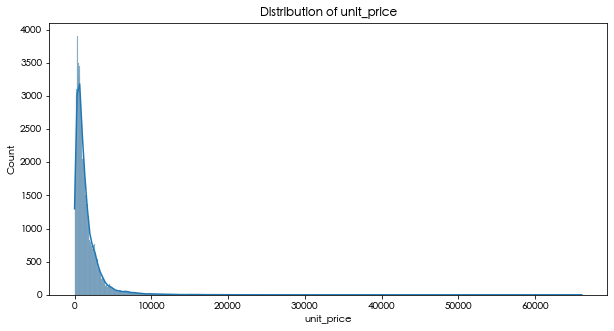

In [50]:
# show the distribution of the unit_price
plt.figure(figsize=(10, 5))
sns.histplot(train_items_feature['unit_price'], kde=True)
plt.title('Distribution of unit_price')
plt.show()


In [51]:
# show the top 10 items with the highest unit_price and lowest unit_price
print("Top 10 items with the highest unit_price")
print(train_items_feature.sort_values('unit_price', ascending=False).head(10))
print("\n\n")
print("Top 10 items with the lowest unit_price")
print(train_items_feature.sort_values('unit_price', ascending=True).head(10))
print("\n\n")

Top 10 items with the highest unit_price
       item_ID                                                       item_name         brand channel size gender class_map  price_range style_50 color_50  unit_price  discount    sale_price
98837  1669951                                          Gucci/古驰 武林特卖商品 300099      BURBERRY  others    U     未知        帽子          1.0       经典     米色系列     66076.0  0.267948  17704.938264
91546  1628673          Max Mara麦丝玛拉 女士山羊绒宽翻领直筒版长款大衣外套【RIENZA 驼色 38】300095（虚库）      MAX MARA  others   38      女        上装          2.0       优雅     米色系列     41320.0  0.736542  30433.910873
91547  1628674          Max Mara麦丝玛拉 女士山羊绒宽翻领直筒版长款大衣外套【RIENZA 驼色 36】300095（虚库）      MAX MARA  others   36      女        上装          2.0       优雅     米色系列     41320.0  0.736542  30433.910873
72388  1552233                     LOEWE/罗意威 2022秋冬 男士 皮衣 【H526Y19L51 2429 46】         LOEWE  others   46      男        上装          1.0       奢华     棕色系列     39080.0  0.815866  31884.058455
6469   13

In [52]:
# show the items counts that sale_price less than 1
train_items_feature[train_items_feature['sale_price'] < 1].shape[0] # 2044 items have sale_price less than 1

2044

## 2.2 User Features

Try to get more User profiles as features by feature engineering, which is based on the purchase history of the user.

### Explore the user purchase profiles by EDA

In [20]:
train_interactions.shape, train_interactions.head(2)

((613807, 3),
    user_id  item_ID  order_time
 0   209227  1595587  2024-03-14
 1   243637  1639001  2024-03-14)

In [22]:
# is there replicates in the train_interactions data?
train_interactions.duplicated().sum() # a lot of replicates in the train_interactions data

4598

In [23]:
# show the top10 replicates in the train_interactions data, and show how many times they are replicated with a col name of 'purchase_counts'
train_interactions_replicate = train_interactions[train_interactions.duplicated()].value_counts().reset_index()
train_interactions_replicate.columns = ['user_id',  'item_ID','order_time' ,'purchase_counts']
train_interactions_replicate.head(10) # for items_ID 1518144, user_id 221475 purchased 161 times on the same day.

user_id  item_ID  order_time  purchase_counts
0   221475  1518144  2021-12-21              161
1        2  1504215  2023-07-21               23
2        2  1519537  2023-07-21               23
3   170043  1504215  2023-07-21               23
4   170043  1519537  2023-07-21               23
5    88405  1580817  2023-02-06               18
6   221475  1518144  2021-12-22               15
7        2  1504214  2023-07-21               14
8   170043  1504214  2023-07-21               14
9   245519  1432018  2022-07-13               14

In [24]:
# how many purchases in total for each item_ID in the above table
train_interactions_replicate.groupby('item_ID')[
    'purchase_counts'].sum().sort_values(ascending=False) # for items_ID 1518144, the total purchase is 211, while user_id 221475 purchased 200 times in total.

item_ID
1518144    211
1432023     56
1504215     52
1519537     52
1504214     45
1433132     34
1432025     27
1432018     25
1580817     22
1521672     19
1524926     19
1509370     19
1493310     18
1522525     17
1521669     16
1366929     16
1535900     15
1522213     15
1535899     15
1512684     14
1546436     14
1535948     12
1449773     12
1506143     12
1535947     12
1489802     12
1519207     11
1501099     10
1487369     10
1432014      9
1503703      9
1467938      9
1527062      8
1468542      8
1546807      8
1662438      8
1437899      8
1531806      8
1535904      8
1437883      8
1432011      7
1543154      7
1507940      7
1489800      7
1535526      7
1508549      7
1496971      7
1521537      7
1524400      7
1521217      6
1641314      6
1432015      6
1535527      6
1501118      6
1490015      6
1535898      6
1535905      6
1560487      6
1489801      6
1524401      6
1482157      6
1512685      6
1468865      6
1521668      6
1544259      6
1506142      6
15

In [25]:
# show the user_id and counts of the purchases for items_ID in [1518144 ]
train_interactions_replicate[
    train_interactions_replicate['item_ID'] == 1518144
    ].groupby('user_id')['purchase_counts'].sum().sort_values(ascending=False)

user_id
221475    200
182156      4
264437      2
54121       1
64689       1
195123      1
248832      1
255004      1
Name: purchase_counts, dtype: int64

In [26]:
# show the train_interactions_replicate.head(15) in the train_items data
train_items[train_items.item_ID.isin(train_interactions_replicate.head(15).item_ID)]

item_ID                                          item_name  \
4109   1366929                                              西有灵犀卡   
12274  1432018  EMPORIO ARMANI/阿玛尼 EA字母设计 男士深蓝色圆领T恤(二件装)，【CC71...   
29993  1487369       设计师品牌 IMMI 女士袜口贴片中筒袜【111SO001B 棕色 00F】300124   
40879  1504214                  Rains 2021春夏 笔袋 【1662 01 Black U】   
40880  1504215                  Rains 2021春夏 笔袋 【1662 03 Green U】   
50322  1518144                      Valeria Obbaco VO 赠品帆布袋300210   
51426  1519537                      MAISON KITSUNE THANK YOU印花帆布包   
82220  1580817  LEGO乐高speed超级赛车76917GT-R R34速度与激情男孩汽车积木玩具【7691...   

                brand channel  unit_price category size               color  \
4109           others  others     2018.00     定制礼盒    U                  黑色   
12274  EMPORIO ARMANI  others       87.00       T恤    S                 深蓝色   
29993            IMMI      54       75.53       袜品    U                  棕色   
40879          others  others        1.00      零钱包    U                  黑色   
40880          others  others        1.00      零钱包    U                  绿色   
50322          others       2        1.00      手提包    U                  白色   
51426  MAISON KITSUNE  others        1.00       草鞋    U                 NaN   
82220          others  others      186.00       积木    U  76917 Skyline GT-R   

       discount gender class_map  bk_sku_id category.1 style  \
4109   1.000000     未知        帽子        NaN        NaN   NaN   
12274  0.085294      男        上装  1432018.0   T恤衫（二件装）  时尚休闲   
29993  0.472062      女        帽子        NaN        NaN   NaN   
40879  0.006711     未知        箱包        NaN        NaN   NaN   
40880  0.006711     未知        箱包        NaN        NaN   NaN   
50322  0.010101     未知        箱包        NaN        NaN   NaN   
51426  0.002000     未知        鞋靴        NaN        NaN   NaN   
82220  0.746988      男        帽子        NaN        NaN   NaN   

      brand_location_map materials_map  sex country_size country_in_stock  \
4109                 NaN           NaN  NaN          NaN              NaN   
12274              ITALY    #95%棉#5%氨纶    男          常规码              NaN   
29993              CHINA           NaN  NaN          NaN            CHINA   
40879                NaN           NaN  NaN          常规码              NaN   
40880                NaN           NaN  NaN          常规码              NaN   
50322                NaN           NaN  NaN          NaN              NaN   
51426             FRANCE           NaN  NaN  法国 (FR)/常规码           FRANCE   
82220                NaN           NaN  NaN          NaN              NaN   

               tag  price_range  country style_50 color_50   sale_price  
4109      运动&功能&潮流          NaN      NaN     运动潮流     黑色系列  2018.000000  
12274   经典&商务&意大利风          4.0      常规码     高端时尚    深蓝色系列     7.420588  
29993  中性色调 天然环保面料          2.0      NaN     艺术风格     棕色系列    35.654881  
40879     简约&防水&实用          2.0      常规码      户外风     黑色系列     0.006711  
40880     简约&防水&实用          2.0      常规码      户外风     绿色系列     0.006711  
50322     高雅&独特&现代          NaN      NaN       优雅     白色系列     0.010101  
51426  法式 年轻 休闲 学院          3.0  法国 (FR)       现代      NaN     0.002000  
82220     创意&多彩&趣味          NaN      NaN     个性街头   特殊颜色系列   138.939759

In [27]:
# is there replicates in the user_id and item_ID?
train_interactions[['user_id',  'item_ID']].duplicated().sum() # there are a lot of times that the same user buy the same item multiple times

28397

In [60]:
# show top items with replicates for each train_interactions[['user_id',  'item_ID']]
train_interactions[['user_id',  'item_ID']].value_counts().head(10)


user_id  item_ID
221475   1518144    205
88405    1432023     72
         1524926     46
         1493310     44
         1519207     41
         1433132     40
         1503694     39
         1432025     39
         1468542     38
         1535900     34
dtype: int64

In [61]:
# show the items with item_ID in the above list
train_items[train_items.item_ID.isin(train_interactions[['user_id',  'item_ID']].value_counts().head(10).index.get_level_values(1))]


item_ID                                                       item_name                    brand channel  unit_price category size   color  discount gender class_map  bk_sku_id category.1 style brand_location_map       materials_map  sex         country_size country_in_stock             tag  price_range              country style_50 color_50  sale_price  final_price
12276  1432023   EMPORIO ARMANI/阿玛尼 简约LOGO设计 男士T恤(二件装)， 【111267 CC717 10410 M】           EMPORIO ARMANI  others       84.00       T恤    M  白色/深蓝色  0.082353      男        上装  1432023.0   T恤衫（二件装）  时尚休闲              ITALY          #95%棉#5%氨纶    男                  常规码              NaN      经典&商务&意大利风          4.0                  常规码     高端时尚     白色系列    6.917647     6.917647
12278  1432025   EMPORIO ARMANI/阿玛尼 简约LOGO设计 男士T恤(二件装)， 【111267 CC717 10410 S】           EMPORIO ARMANI      15      117.00       T恤    S  白色/深蓝色  0.114706      男        上装  1432025.0   T恤衫（二件装）  时尚休闲              ITALY          #95%棉#5%氨纶    男                  常规码              NaN      经典&商务&意大利风          4.0                  常规码     高端时尚     白色系列   13.420588    13.420588
12480  1433132                     BY FAR 女士复古棕色花纹设计潮流手提单肩包，【18FWRCLSNEDMED M】                   BY FAR  others      439.92      单肩包    U      棕色  0.126015      女        箱包  1433132.0        手提包  百搭时尚           BULGARIA             牛皮革, 织物    女                  NaN         BULGARIA      现代&马卡龙色&少女          2.0                  NaN       奢华     棕色系列   55.436725    55.436725
21744  1468542     AMI ALEXANDRE MATTIUSSI 简约经典爱心装饰男士休闲短裤，【E21HBW03 393 410 S】  AMI ALEXANDRE MATTIUSSI      54      426.37       短裤    S     深蓝色  0.250806      男        裤子  1468542.0         短裤  时尚都市             FRANCE  #100%锦纶, #100%聚酯纤维    男              法国 (FR)           FRANCE        法式&休闲&中性          2.0              法国 (FR)     高端时尚    深蓝色系列  106.936104   106.936104
33070  1493310                     PRADA/普拉达 2021春夏 男士 手拿包 【2NH006 064F0002 U】                    PRADA  others     2195.00      手拿包    U      黑色  0.385088      男        箱包  1493310.0        手拿包  质轻耐用              ITALY         织物, 织物/牛剖层革    男  意大利 (IT)/鞋靴为英国码（UK)              NaN        创新&前卫&简约          5.0  意大利 (IT)/鞋靴为英国码（UK)     高端时尚     黑色系列  845.267544   845.267544
40411  1503694             PINKO/品高 经典简约飞燕LOGO装饰女士单肩斜挎链条包, 【1P22A4 Y6XT Z99 U】                    PINKO  others      719.00      斜挎包    U      黑色  0.322422      女        箱包  1503694.0        单肩包  性感独立              ITALY          牛皮剖层革, 合成革    女             意大利 (IT)           ITALIA  优雅 性感 色彩 职业 少女          2.0             意大利 (IT)       优雅     黑色系列  231.821076   231.821076
50322  1518144                                   Valeria Obbaco VO 赠品帆布袋300210                   others       2        1.00      手提包    U      白色  0.010101     未知        箱包        NaN        NaN   NaN                NaN                 NaN  NaN                  NaN              NaN        高雅&独特&现代          NaN                  NaN       优雅     白色系列    0.010101     0.010101
51125  1519207             PINKO/品高 女士简约日常通勤休闲经典燕子金属扣单肩斜挎包，【1P22BT Y7FY Z14 U】                    PINKO  others      615.00      斜挎包    U      白色  0.222022      女        箱包  1519207.0        单肩包  性感独立              ITALY        羊皮革/牛皮革, 合成革    女             意大利 (IT)           ITALIA  优雅 性感 色彩 职业 少女          2.0             意大利 (IT)       优雅     白色系列  136.543321   136.543321
55857  1524926  NewEra纽亦华男女同款针织帽时尚潮流舒适包头帽商场同款【12866279MZ 黑色 56-62CM】301336（虚库）                  NEW ERA      54      287.00       帽子    U      黑色  0.899687     男女        配饰        NaN        NaN   NaN                NaN                 NaN  NaN                  NaN              NaN        运动&街头&年轻          NaN                  NaN      街头风     黑色系列  258.210031   258.210031
63413  1535900               REPRESENT   男士简约纯色运动风套头圆领短袖T恤【M05149-01 BLACK XL】                REPRESENT      54      485.66       T恤   XL      黑色  0.539622      男        上装  1535900.0        T恤衫  街头美学                 UK              #100%棉    男   

In [62]:
# does the items with item_ID in the train_interactions_replicate.head(10) have replicates in the test data?
test_items[test_items.item_ID.isin(train_interactions_replicate.head(10).item_ID)] # no 

Empty DataFrame
Columns: [item_ID, item_name, brand, channel, unit_price, category, size, color, discount, gender, class_map, bk_sku_id, category.1, style, brand_location_map, materials_map, sex, country_size, country_in_stock, tag, price_range, country, style_50, color_50, sale_price]
Index: []

In [63]:
# does the users in the train_interactions_replicate.head(10) in the test data?
test_users[test_users.user_id.isin(train_interactions_replicate.head(10).user_id)] # yes, user_id 2 is in the test data

user_id
1        2

### abnormals removal


In [28]:
# remove the user_id and item_ID combination in train_interactions_replicate.head(5) from the train_interactions data
to_remove = train_interactions_replicate.head(5)[['user_id', 'item_ID']]
train_interactions_filter = train_interactions.merge(to_remove, on=[
    'user_id', 'item_ID'], how='left', indicator=True)
train_interactions_filter = train_interactions_filter[
    train_interactions_filter['_merge'] == 'left_only'].drop(columns=['_merge'])
print(
    'remove {} rows from train_interactions'.format(
        train_interactions.shape[0] - train_interactions_filter.shape[0])
        ) # remove 301 rows from train_interactions

remove 301 rows from train_interactions


In [29]:
train_interactions_filter.head()

user_id  item_ID  order_time
0   209227  1595587  2024-03-14
1   243637  1639001  2024-03-14
2   265503  1675222  2024-03-14
3   183614  1662640  2024-03-14
4   188753  1662540  2024-03-14

In [66]:
# all user_id in the train_interactions_filter are in the train_users
train_interactions_filter[~train_interactions_filter.user_id.isin(train_users.user_id)].shape # all the user_id in the train_interactions_filter are in the train_users

(0, 3)

In [67]:
# all item_ID in the train_interactions_filter are in the train_items
train_interactions_filter[~train_interactions_filter.item_ID.isin(train_items.item_ID)].shape # all the item_ID in the train_interactions_filter are in the train_items

(0, 3)

In [68]:
# SAVE train_interactions_filter
train_interactions_filter.to_csv("train_interactions_filter.csv", index=False)

## 8.2 Load the results into a dataframe

### combined the user and item features

In [30]:
train_user_item = train_interactions_filter.merge(
    train_items_feature, on='item_ID', how='left')
train_user_item.head(2), train_user_item.shape

(   user_id  item_ID  order_time  \
 0   209227  1595587  2024-03-14   
 1   243637  1639001  2024-03-14   
 
                                            item_name     brand channel size  \
 0        BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】  BURBERRY  others    M   
 1  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】30136...    others       2    L   
 
   gender class_map  price_range style_50 color_50  unit_price  discount  \
 0      男        上装          1.0       经典    卡其色系列      2880.0  0.600000   
 1      男        上装          2.0     运动潮流     灰色系列       519.0  0.524242   
 
     sale_price  
 0  1728.000000  
 1   272.081818  ,
 (613506, 15))

In [96]:
train_user_item.item_name.nunique(), train_user_item.item_ID.nunique() 
# item_name is not exactly 1:1 to item_ID. Same item name have different item_ID

(98808, 99893)

In [97]:
# change order_time to datetime, and extract year, month, and season
train_user_item['order_time'] = pd.to_datetime(train_user_item['order_time'])
train_user_item['order_year'] = train_user_item['order_time'].dt.year
train_user_item['order_month'] = train_user_item['order_time'].dt.month
train_user_item['order_season'] = train_user_item['order_month'].apply(
    lambda x: (x%12 + 3)//3)
# change order_year to str, and order_month to str, and order_season to str
train_user_item['order_year'] = train_user_item['order_year'].astype(str)
train_user_item['order_month'] = train_user_item['order_month'].astype(str)
train_user_item['order_season'] = train_user_item['order_season'].astype(str)


### user features by feature engineering

In [98]:
# for each user_id, count the number of items bought, the number of unique items bought, the number of unique brands bought, the number of unique channels bought, the number of unique sizes bought, the number of unique colors bought, the number of unique class_map bought, the number of unique price_range bought, the number of unique style_50 bought, the number of unique color_50 bought, the
# average unit_price, the average discount, the average sale_price

user_feature = train_user_item.groupby('user_id').agg(
    num_items_bought = ('item_ID', 'count'),
    num_unique_items_bought = ('item_ID', 'nunique'),
    num_unique_brands_bought = ('brand', 'nunique'),
    num_unique_channels_bought = ('channel', 'nunique'),
    num_unique_sizes_bought = ('size', 'nunique'),
    num_unique_class_map_bought = ('class_map', 'nunique'),
    num_unique_price_range_bought = ('price_range', 'nunique'),
    num_unique_style_50_bought = ('style_50', 'nunique'),
    num_unique_color_50_bought = ('color_50', 'nunique'),
    # most like item, most like brand, most like channel, most like size, most like class_map, most like price_range, most like style_50, most like color_50
    most_like_brand = ('brand', lambda x: x.value_counts().index[0]),
    #most_like_channel = ('channel', lambda x: x.value_counts().index[0]),
    most_like_size = ('size', lambda x: x.value_counts().index[0]),
    most_like_class_map = ('class_map', lambda x: x.value_counts().index[0]),
    # most_like_price_range = ('price_range', lambda x: x.value_counts().index[0]),
    most_like_style_50 = ('style_50', lambda x: x.value_counts().index[0]),
    most_like_color_50 = ('color_50', lambda x: x.value_counts().index[0]),
    # most buying time, most buying month, most buying season
    # most_buying_time = ('order_year', lambda x: x.value_counts().index[0]),
    # most_buying_month = ('order_month', lambda x: x.value_counts().index[0]),
    # most_buying_season = ('order_season', lambda x: x.value_counts().index[0]),
    # average unit_price, average discount, average sale_price
    # avg_unit_price = ('unit_price', 'mean'),
    avg_discount = ('discount', 'mean'),
    avg_sale_price = ('sale_price', 'mean')
).reset_index()
user_feature.head(2), user_feature.shape

(   user_id  num_items_bought  num_unique_items_bought  \
 0        1                 5                        5   
 1        2               986                      916   
 
    num_unique_brands_bought  num_unique_channels_bought  \
 0                         3                           2   
 1                        72                           4   
 
    num_unique_sizes_bought  num_unique_class_map_bought  \
 0                        3                            3   
 1                       57                            8   
 
    num_unique_price_range_bought  num_unique_style_50_bought  \
 0                              1                           4   
 1                              5                          28   
 
    num_unique_color_50_bought most_like_brand most_like_size  \
 0                           5          others              M   
 1                          25          others              S   
 
   most_like_class_map most_like_style_50 most_like_color_50  avg_

### user outliers identification by EDA

In [73]:
# mean and std of the numerical variables
user_feature.describe() # num_items_bought, num_unique_items_bought look have outliers

user_id  num_items_bought  num_unique_brands_bought   avg_discount  avg_sale_price
count  256475.000000     256475.000000             256475.000000  256475.000000   256475.000000
mean   135268.387847          2.392069                  1.524804       0.515228      701.749400
std     78177.442624         37.568797                  1.683333       0.222248      895.977452
min         1.000000          1.000000                  1.000000       0.000000        0.000000
25%     67570.500000          1.000000                  1.000000       0.357593      205.444444
50%    135287.000000          1.000000                  1.000000       0.510167      447.884822
75%    202952.500000          2.000000                  1.000000       0.675177      880.843179
max    270590.000000      16008.000000                 77.000000       1.358582    31884.058455

In [74]:
# outliers of the numerical variables
# show the top 10 users with the most items bought
user_feature.sort_values(by='num_items_bought', ascending=False).head(20) # the top 3 users look abnormal

user_id  num_items_bought  num_unique_brands_bought          most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50  avg_discount  avg_sale_price
83803     88405             16008                        51                    KENZO              U                  上装                 经典               黑色系列      0.440562      728.432529
138716   146365              6805                        76                   others              U                  上装                 优雅               黑色系列      0.419475      721.000051
209906   221475              5854                        77                   others              U                  上装                 优雅               黑色系列      0.555111      934.688786
100786   106357              1747                        59             MR&MRS ITALY              S                  上装                 奢华               白色系列      0.115641      142.359291
64667     68154              1081                        56                   others              U                  上装                 奢华               黑色系列      0.094949       76.590785
1122       1136              1081                        56                   others              U                  上装                 奢华               黑色系列      0.094949       76.590785
73597     77605              1023                        19  AMI ALEXANDRE MATTIUSSI              S                  上装               高端时尚               黑色系列      0.538156     1547.018782
161146   170043               986                        72                   others              S                  上装                 优雅               黑色系列      0.325933      421.552712
1             2               986                        72                   others              S                  上装                 优雅               黑色系列      0.325933      421.552712
161704   170635               971                        57                   others              U                  上装                 奢华               黑色系列      0.174348      200.916932
212816   224547               968                        54                   others              S                  上装                 优雅               白色系列      0.189896      182.535534
95823    101101               947                        35                   others              S                  上装                 优雅               黑色系列      0.662315      701.174605
11           12               947                        35                   others              S                  上装                 优雅               黑色系列      0.662315      701.174605
195590   206348               894                        60                   others              S                  上装                 优雅               黑色系列      0.249852      308.887602
172616   182159               886                        49                   others              S                  上装                 优雅               白色系列      0.124518       76.961084
189624   200101               843                        59                   others              S                  上装                 优雅               黑色系列      0.627524     1085.227004
79235     83575               797                        30                    KENZO              M                  上装                 前卫               黑色系列      0.404769      642.422839
133839   141197               749                        52                   others              U                  上装                 奢华               黑色系列      0.113623      141.907454
60003     63194               726                        48                   others              U                  上装                 优雅               黑色系列      0.111265      148.221985
182497   192595               721                        50                   others              U                  上装                 优雅               黑色系列      0.118485      107.353027

In [50]:
# are these 3 users in the test data?
print(test_users[test_users.user_id.isin([88405, 146365, 221475])]) # no, they are not in the test data

Empty DataFrame
Columns: [user_id]
Index: []


In [76]:
# the top 3 users definitely are outliers, remove them
# user_feature = user_feature[~user_feature.user_id.isin([88405, 146365, 221475])]

In [99]:
user_feature.columns

Index(['user_id', 'num_items_bought', 'num_unique_items_bought',
       'num_unique_brands_bought', 'num_unique_channels_bought',
       'num_unique_sizes_bought', 'num_unique_class_map_bought',
       'num_unique_price_range_bought', 'num_unique_style_50_bought',
       'num_unique_color_50_bought', 'most_like_brand', 'most_like_size',
       'most_like_class_map', 'most_like_style_50', 'most_like_color_50',
       'avg_discount', 'avg_sale_price'],
      dtype='object')

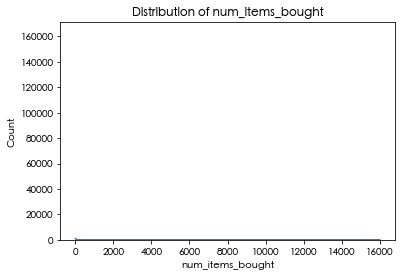

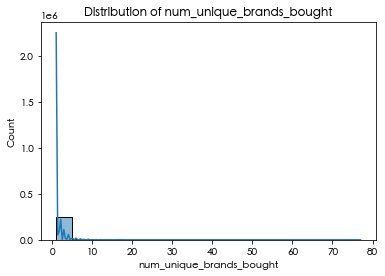

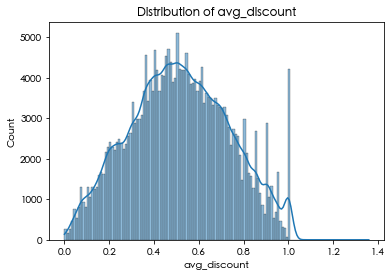

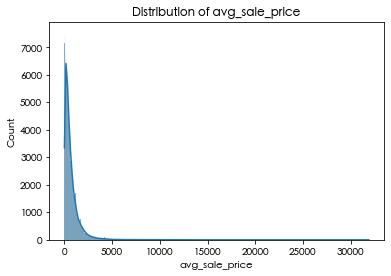

In [78]:
# show the distribution of the numerical variables
columns_to_plot = ['num_items_bought', 
                   'num_unique_brands_bought', 
                   'avg_discount', 
                   'avg_sale_price']
for col in columns_to_plot:
    # plt.figure(figsize=(10, 5))
    sns.histplot(user_feature[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
        

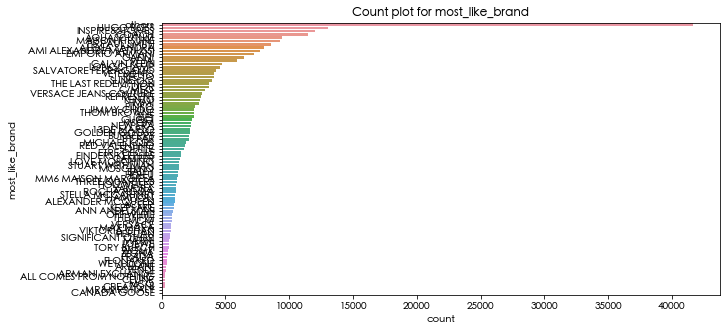

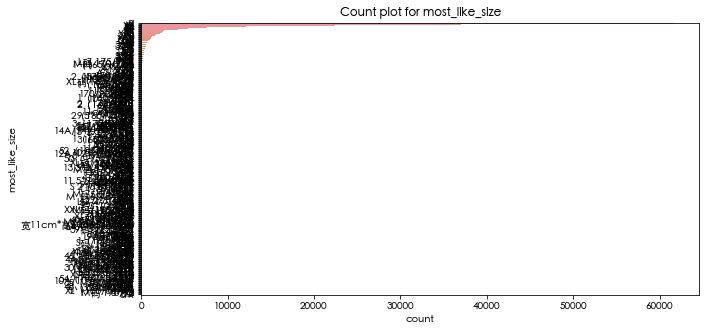

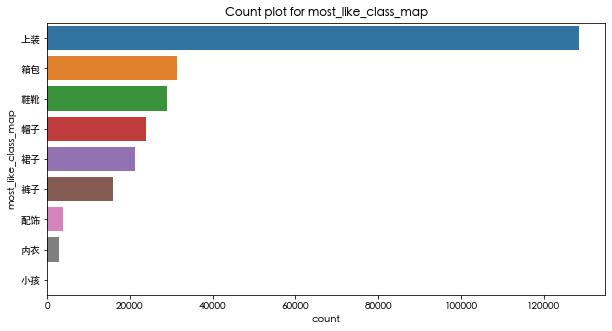

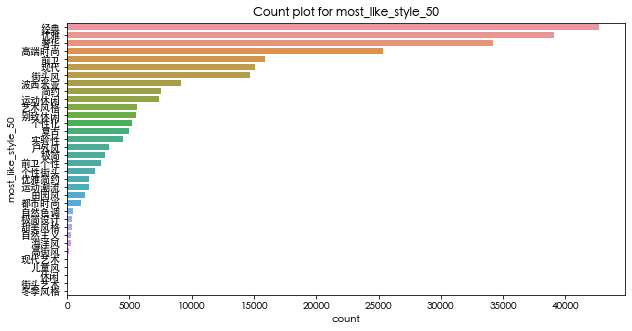

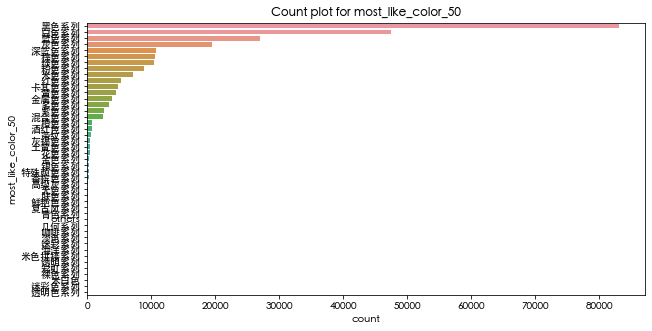

In [79]:
# show the distribution of the categorical variables
columns_to_count = ['most_like_brand', 
                    'most_like_size', 
                    'most_like_class_map', 
                    'most_like_style_50', 
                    'most_like_color_50']
for col in columns_to_count:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, 
                  data=user_feature,
                  order=user_feature[col].value_counts().index)
    plt.title(f'Count plot for {col}')
    plt.show()

    

In [100]:
user_feature.columns

Index(['user_id', 'num_items_bought', 'num_unique_items_bought',
       'num_unique_brands_bought', 'num_unique_channels_bought',
       'num_unique_sizes_bought', 'num_unique_class_map_bought',
       'num_unique_price_range_bought', 'num_unique_style_50_bought',
       'num_unique_color_50_bought', 'most_like_brand', 'most_like_size',
       'most_like_class_map', 'most_like_style_50', 'most_like_color_50',
       'avg_discount', 'avg_sale_price'],
      dtype='object')

In [52]:
user_feature_select = ['user_id', 
                       'num_items_bought', 
                    #    'num_unique_brands_bought', 
                       'avg_discount', 
                       'avg_sale_price', 
                       'most_like_brand', 
                       'most_like_size', 
                       'most_like_class_map', 
                       'most_like_style_50', 
                       'most_like_color_50']
user_profile = user_feature[user_feature_select]
user_profile.head(2), user_profile.shape

(   user_id  num_items_bought  avg_discount  avg_sale_price most_like_brand  \
 0        1                 5      0.643710      835.417766          others   
 1        2               986      0.325933      421.552712          others   
 
   most_like_size most_like_class_map most_like_style_50 most_like_color_50  
 0              M                  上装                 优雅              深蓝色系列  
 1              S                  上装                 优雅               黑色系列  ,
 (256475, 9))

### combineded user and item features

In [53]:
# add user_feature to train_user_item_feature by user_id
train_user_item_final = train_user_item.merge(user_profile, on='user_id', how='left')
train_user_item_final.shape

(613506, 26)

In [54]:
# drop 'order_month', 'order_season', 'order_year' from train_user_item_final
train_user_item_final.drop(columns=['order_month', 'order_season', 'order_year'], inplace=True)


In [55]:
train_user_item_final.shape, train_user_item_final.head(2)

((613506, 23),
    user_id  item_ID order_time  \
 0   209227  1595587 2024-03-14   
 1   243637  1639001 2024-03-14   
 
                                            item_name     brand channel size  \
 0        BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】  BURBERRY  others    M   
 1  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】30136...    others       2    L   
 
   gender class_map  price_range style_50 color_50  unit_price  discount  \
 0      男        上装          1.0       经典    卡其色系列      2880.0  0.600000   
 1      男        上装          2.0     运动潮流     灰色系列       519.0  0.524242   
 
     sale_price  num_items_bought  avg_discount  avg_sale_price  \
 0  1728.000000                 3      0.682828     1751.919192   
 1   272.081818                 2      0.524242      272.081818   
 
            most_like_brand most_like_size most_like_class_map  \
 0  AMI ALEXANDRE MATTIUSSI              M                  上装   
 1                   others              L                  上装   
 
   

In [56]:
train_user_item_final.isnull().mean()*100 # no missing values

user_id                0.0
item_ID                0.0
order_time             0.0
item_name              0.0
brand                  0.0
channel                0.0
size                   0.0
gender                 0.0
class_map              0.0
price_range            0.0
style_50               0.0
color_50               0.0
unit_price             0.0
discount               0.0
sale_price             0.0
num_items_bought       0.0
avg_discount           0.0
avg_sale_price         0.0
most_like_brand        0.0
most_like_size         0.0
most_like_class_map    0.0
most_like_style_50     0.0
most_like_color_50     0.0
dtype: float64

In [86]:
# # fill NA with the most frequent value for the categorical variables, and fill NA with the mean for the numerical variables
# for col in user_profile.columns:
#     if user_profile[col].dtype == 'object':
#         train_user_item_final[col] = train_user_item_final[col].fillna(user_profile[col].mode()[0])
#     else:
#         train_user_item_final[col] = train_user_item_final[col].fillna(user_profile[col].mean())

# train_user_item_final.isnull().mean()*100 

In [87]:
# CHECK if user_id 88405, 146365, 221475 is in the train_user_item_final
train_user_item_final[train_user_item_final.user_id.isin([88405, 146365, 221475])].shape # no, they are removed


(28667, 23)

In [101]:
user_feature.isnull().mean()*100

user_id                          0.0
num_items_bought                 0.0
num_unique_items_bought          0.0
num_unique_brands_bought         0.0
num_unique_channels_bought       0.0
num_unique_sizes_bought          0.0
num_unique_class_map_bought      0.0
num_unique_price_range_bought    0.0
num_unique_style_50_bought       0.0
num_unique_color_50_bought       0.0
most_like_brand                  0.0
most_like_size                   0.0
most_like_class_map              0.0
most_like_style_50               0.0
most_like_color_50               0.0
avg_discount                     0.0
avg_sale_price                   0.0
dtype: float64

In [102]:
# save user_profile
user_feature.to_csv("user_profile.csv", index=False)

In [33]:
# reload user_profile
user_profile = pd.read_csv("user_profile.csv")
user_profile.head(2)

user_id  num_items_bought  avg_discount  avg_sale_price most_like_brand  \
0        1                 5      0.643710      835.417766          others   
1        2               986      0.325933      421.552712          others   

  most_like_size most_like_class_map most_like_style_50 most_like_color_50  
0              M                  上装                 优雅              深蓝色系列  
1              S                  上装                 优雅               黑色系列

# 3. Labeling

## 3.1 Positive Labels

All the happened purchases are positive.

In [38]:
pos_samples = train_user_item_final.drop(["order_time", ], axis=1)

In [39]:
pos_samples.head(2), pos_samples.shape # 613k positive samples

(   user_id  item_ID                                          item_name  \
 0   209227  1595587        BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】   
 1   243637  1639001  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】30136...   
 
       brand channel size gender class_map  price_range style_50 color_50  \
 0  BURBERRY  others    M      男        上装          1.0       经典    卡其色系列   
 1    others       2    L      男        上装          2.0     运动潮流     灰色系列   
 
    unit_price  discount   sale_price  num_items_bought  avg_discount  \
 0      2880.0  0.600000  1728.000000                 3      0.682828   
 1       519.0  0.524242   272.081818                 2      0.524242   
 
    avg_sale_price          most_like_brand most_like_size most_like_class_map  \
 0     1751.919192  AMI ALEXANDRE MATTIUSSI              M                  上装   
 1      272.081818                   others              L                  上装   
 
   most_like_style_50 most_like_color_50  
 0               高端时尚       

In [40]:
pos_samples["label"] = 1

## 3.2 Negative Sampling

We can randomly pair an user and an item and assume this purchase will not happen (negative data). 

I will remove those negative samples that are actually positive.

Keep pos: neg = 1:4

In [41]:
pos_num = len(pos_samples)*4

In [42]:
import random
random.seed(2024)# set random seed 

neg_samples = {"user_id":[], "item_ID":[]}
for i in range(pos_num):
    uid = random.choice(train_users["user_id"])
    neg_samples["user_id"].append(uid)
    
    iid = random.choice(train_items["item_ID"])
    neg_samples["item_ID"].append(iid)

In [43]:
neg_samples = pd.DataFrame(neg_samples)

# check the combination of user_id and item_ID in the neg_samples, if they appear in the pos_samples, remove them
neg_samples = neg_samples[~neg_samples.set_index(['user_id', 'item_ID']).index.isin(pos_samples.set_index(['user_id', 'item_ID']).index)]
# check length of neg_samples
len(neg_samples)

2453970

In [44]:
neg_samples["label"] = 0

In [45]:
neg_samples.head(2)

user_id  item_ID  label
0   130011  1473355      0
1   201440  1560353      0

In [46]:
# add train_items_feature to neg_samples by item_ID
neg_samples = neg_samples.merge(train_items_feature, on='item_ID', how='left')
neg_samples.head(2), neg_samples.shape


(   user_id  item_ID  label                                          item_name  \
 0   130011  1473355      0  BOTTEGA VENETA 女士 云朵包手拿包 【576227-VCP40 棕色】 300221   
 1   201440  1560353      0     Hugo boss/雨果博斯 2022秋冬 男士 休闲夹克 【50471688 001 L】   
 
        brand channel size gender class_map  price_range style_50 color_50  \
 0     others      15    U      女        箱包          2.0       奢华     棕色系列   
 1  HUGO BOSS      54    L      男        上装          2.0       经典     黑色系列   
 
    unit_price  discount   sale_price  
 0      2640.0  0.122222   322.666667  
 1      3420.0  0.960674  3285.505618  ,
 (2453970, 15))

In [57]:
# add user_feature_select to neg_samples by user_id
neg_samples = neg_samples.merge(user_feature[user_feature_select], on='user_id', how='left')
neg_samples.head(2), neg_samples.shape

(   user_id  item_ID  label                                          item_name  \
 0   130011  1473355      0  BOTTEGA VENETA 女士 云朵包手拿包 【576227-VCP40 棕色】 300221   
 1   201440  1560353      0     Hugo boss/雨果博斯 2022秋冬 男士 休闲夹克 【50471688 001 L】   
 
        brand channel size gender class_map  price_range style_50 color_50  \
 0     others      15    U      女        箱包          2.0       奢华     棕色系列   
 1  HUGO BOSS      54    L      男        上装          2.0       经典     黑色系列   
 
    unit_price  discount   sale_price  num_items_bought  avg_discount  \
 0      2640.0  0.122222   322.666667                 1      0.784444   
 1      3420.0  0.960674  3285.505618                 1      0.363462   
 
    avg_sale_price most_like_brand most_like_size most_like_class_map  \
 0     2769.088889     THOM BROWNE             38                  上装   
 1      686.942308           COACH              U                  箱包   
 
   most_like_style_50 most_like_color_50  
 0                 经典          

In [58]:
neg_samples.shape, pos_samples.shape # check the shape of neg_samples and pos_samples

((2453970, 23), (613506, 23))

In [59]:
# different columns in pos_samples and neg_samples
set(pos_samples.columns) - set(neg_samples.columns), 
set(neg_samples.columns) - set(pos_samples.columns) # neg and po have the same columns


set()

# 4. Training Data Preparation

## 4.1 Concatenation

In [60]:
# combined pos_samples and neg_samples together
train_data = pd.concat([pos_samples, neg_samples]).reset_index(drop=True)

In [210]:
train_data.head(2) # make sure pos and neg are combined correctly

user_id  item_ID                                            item_name     brand channel size gender class_map  price_range style_50 color_50  unit_price  discount   sale_price  num_items_bought  avg_discount  avg_sale_price          most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50  label
0   209227  1595587          BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】  BURBERRY  others    M      男        上装          1.0       经典    卡其色系列      2880.0  0.600000  1728.000000                 3      0.682828     1751.919192  AMI ALEXANDRE MATTIUSSI              M                  上装               高端时尚              卡其色系列      1
1   243637  1639001  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】301365（虚库）    others       2    L      男        上装          2.0     运动潮流     灰色系列       519.0  0.524242   272.081818                 2      0.524242      272.081818                   others              L                  上装               运动潮流               灰色系列      1

In [211]:
train_data.tail(2) # make sure pos and neg are combined correctly

user_id  item_ID                                                                       item_name        brand channel size gender class_map  price_range style_50 color_50  unit_price  discount   sale_price  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50  label
3067474     7791  1327785  Celestine金色925银材质银河星际圆圈珍珠不对称耳环  3E03 YELLOW GOLD WOMEN Galaxy Earring ONE SIZE       others  others    U     未知        帽子          2.0       优雅    金属色系列       299.0  0.213571    63.857857                 1      0.621477     1660.803377    GOLDEN GOOSE             35                  鞋靴                 复古               白色系列      0
3067475   189461  1629100                                      THOM BROWNE 男士 POLO衫 【MJP169A-J0046 415 2】  THOM BROWNE      54    2      男        上装          3.0       经典    深蓝色系列      3750.8  0.528282  1981.478963                 1      0.342000      116.964000   PS PAUL SMITH              M                  上装                 经典               黑色系列      0

In [61]:
# change price_range to str, drop item_name,
train_data['price_range'] = train_data['price_range'].astype(str)
train_data.dtypes

user_id                  int64
item_ID                  int64
item_name               object
brand                   object
channel                 object
size                    object
gender                  object
class_map               object
price_range             object
style_50                object
color_50                object
unit_price             float64
discount               float64
sale_price             float64
num_items_bought         int64
avg_discount           float64
avg_sale_price         float64
most_like_brand         object
most_like_size          object
most_like_class_map     object
most_like_style_50      object
most_like_color_50      object
label                    int64
dtype: object

In [62]:

# check missing
train_data.isnull().mean()*100 # no

user_id                0.0
item_ID                0.0
item_name              0.0
brand                  0.0
channel                0.0
size                   0.0
gender                 0.0
class_map              0.0
price_range            0.0
style_50               0.0
color_50               0.0
unit_price             0.0
discount               0.0
sale_price             0.0
num_items_bought       0.0
avg_discount           0.0
avg_sale_price         0.0
most_like_brand        0.0
most_like_size         0.0
most_like_class_map    0.0
most_like_style_50     0.0
most_like_color_50     0.0
label                  0.0
dtype: float64

In [63]:
# save to csv
# train_data.to_csv("train_data.csv", index=False)
# save the combination of user_id and item_ID in the train_data
train_data[["user_id", "item_ID"]].to_csv("train_interaction.csv", index=False)

In [43]:
# reload train_data
train_data = pd.read_csv("train_data.csv")

## 4.3 Splitting Features and Labels

In [213]:
y_train = train_data["label"]

In [ ]:
features = list(train_data.columns)
features.remove("label")
features.remove("user_id")
features.remove("item_ID")
features.remove("item_name")

In [215]:
# split the dataset as training and testing at 80% and 20%, keep ratios of positive and negative samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data[features], y_train, test_size=0.2, stratify=y_train, random_state=42)


In [216]:
X_train.head(2)

user_id        brand channel size gender class_map price_range style_50 color_50  unit_price  discount   sale_price  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50
2291764   231946     MOSCHINO      54   44      女        上装         5.0     前卫个性     黑色系列     3046.04  0.554834  1690.047301                 1      0.605471      623.210876          others              7                  鞋靴                街头风               黑色系列
622371     27672  THOM BROWNE      54    2      男        裤子         3.0       经典     灰色系列     2037.02  0.433409   882.861804                 1      1.000000     1050.000000       LONGCHAMP              U                  箱包                 经典               紫色系列

# 5. Modeling I: Logistics Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score




In [223]:
# set up pipeline for logistic regression, deal with numerical variables with standard scaler, and deal with categorical variables with one hot encoder

# numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns

# pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# full pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# logistic regression model with increased max_iter, and n_jobs=-1, class weight balanced
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, 
                                        random_state=42,
                                        class_weight='balanced',
                                      n_jobs=-1))
])

# fit the model
model.fit(X_train, y_train)

# predict the test data
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy_score(y_test, y_pred)

# calculate the confusion matrix
confusion_matrix(y_test, y_pred)

# calculate the precision, recall, f1 score
precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)

# calculate the roc_auc score
roc_auc_score(y_test, y_pred)


/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6603845418285733

In [241]:
confusion_matrix(y_test, y_pred)


array([[368060, 122735],
       [ 52658,  70043]])

In [224]:
# calculate the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.75      0.81    490795
           1       0.36      0.57      0.44    122701

    accuracy                           0.71    613496
   macro avg       0.62      0.66      0.63    613496
weighted avg       0.77      0.71      0.73    613496



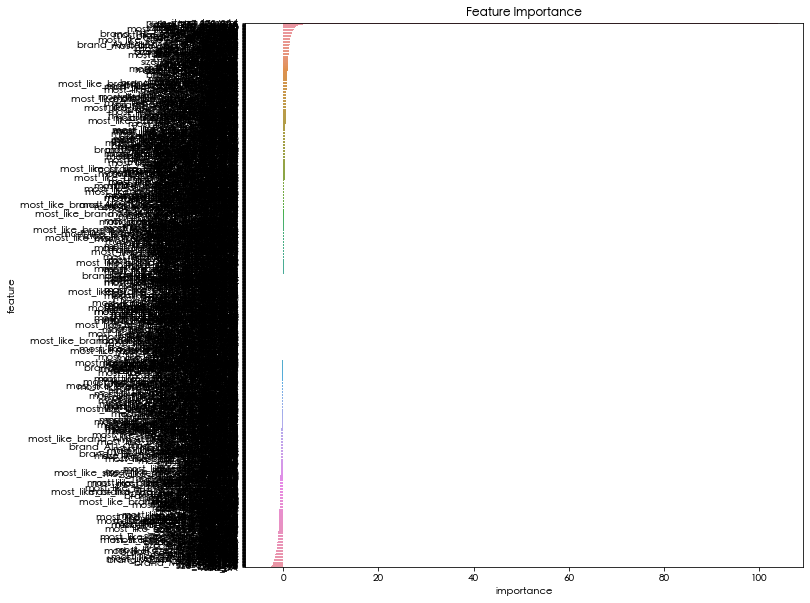

In [116]:
# feature importance
# get the feature names
feature_names = model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names(categorical_features)
feature_names = np.concatenate([numerical_features, feature_names])
# get the coefficients of the logistic regression model
coefs = model.named_steps['classifier'].coef_[0]
# create a dataframe for the feature importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coefs}).sort_values(by='importance', ascending=False)
# plot the feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature importance')
plt.show()


In [117]:
# show the top 20 most important features, and their corresponding importance, both positive and negative
feature_importance.head(20), feature_importance.tail(20)


(                   feature  importance
 3         num_items_bought  103.941328
 603        size_M码 170/92A    5.347831
 579        size_L码 175/96A    5.243132
 1202     most_like_size_6m    4.084503
 670      size_XL码 180/100A    4.049681
 142          size_10cm*1cm    3.411523
 147        size_11*2*9.5cm    3.227407
 561                 size_F    2.952701
 644              size_T 38    2.762998
 645              size_T 40    2.642818
 151    size_11.5*9.5*1.5cm    2.535494
 1118     most_like_size_3M    2.508190
 823          color_50_无色系列    2.479199
 1356  most_like_size_欧洲码40    2.466887
 544             size_9（43）    2.401872
 157          size_11cm*1cm    2.399117
 128          size_10*1*8cm    2.294740
 240               size_26W    2.255163
 591        size_M\n170/72A    2.182814
 235               size_25W    2.169982,
                 feature  importance
 413             size_4A   -1.884045
 732           size_欧码39   -1.891960
 717          size_欧洲码40   -1.934538
 719       

# 6. Test Dataset Preparation

## 6.1 Item Features

In [85]:
test_items_feature.head(2), test_items_feature.shape

(   item_ID                                          item_name          brand  \
 0  1657680  Alexia Sandra 牛仔系列 女士简约松紧腰牛仔长裤【477948NZ4K9605 ...  ALEXIA SANDRA   
 1  1525546      CAMPER 女士经典黑色简约日常圆头针扣系带休闲凉鞋，【K200573-012 36】,         CAMPER   
 
   channel size gender class_map  price_range style_50 color_50  unit_price  \
 0      54    S      女        裤子          2.0       优雅     蓝色系列      871.46   
 1      54   36      女        鞋靴          3.0      户外风     黑色系列      635.34   
 
    discount  sale_price  
 0  0.738525  643.595366  
 1  0.635976  404.060977  ,
 (11510, 13))

In [86]:

# change price_range to str, drop item_name,
test_items_feature['price_range'] = test_items_feature['price_range'].astype(str)
test_items_feature.isnull().mean()*100 # NO missing values


item_ID        0.0
item_name      0.0
brand          0.0
channel        0.0
size           0.0
gender         0.0
class_map      0.0
price_range    0.0
style_50       0.0
color_50       0.0
unit_price     0.0
discount       0.0
sale_price     0.0
dtype: float64

## 6.2 User Features

In [87]:
test_users = pd.read_csv("test_users.csv")
test_users.head(2), test_users.shape

(   user_id
 0        1
 1        2,
 (1333, 1))

In [282]:
# load user_profile
user_profile = pd.read_csv("user_profile.csv")
user_profile.head(2), user_profile.shape

(   user_id  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50
 0        1                 5      0.643710      835.417766          others              M                  上装                 优雅              深蓝色系列
 1        2               986      0.325933      421.552712          others              S                  上装                 优雅               黑色系列,
 (256475, 9))

In [88]:
# merge user_profile to test_users by user_id
test_user = test_users.merge(user_profile, on='user_id', how='left')
test_user.head(2), test_user.shape

(   user_id  num_items_bought  avg_discount  avg_sale_price most_like_brand  \
 0        1                 5      0.643710      835.417766          others   
 1        2               986      0.325933      421.552712          others   
 
   most_like_size most_like_class_map most_like_style_50 most_like_color_50  
 0              M                  上装                 优雅              深蓝色系列  
 1              S                  上装                 优雅               黑色系列  ,
 (1333, 9))

In [90]:
test_user.isnull().mean()*100 #  no missing values

user_id                0.0
num_items_bought       0.0
avg_discount           0.0
avg_sale_price         0.0
most_like_brand        0.0
most_like_size         0.0
most_like_class_map    0.0
most_like_style_50     0.0
most_like_color_50     0.0
dtype: float64

In [285]:
# save to csv
test_user.to_csv("test_user_feature.csv", index=False)

# 7. Recommend items for one user

## 7.1 Create interaction data for an user

In [150]:
uid = 1245

In [247]:
test_interactions = pd.DataFrame()
test_interactions["item_ID"] = test_items_feature["item_ID"]
test_interactions["user_id"] = uid

In [248]:
test_interactions.head(2), test_interactions.shape

(   item_ID  user_id
 0  1657680        1
 1  1525546        1,
 (11510, 2))

## 7.2 Add features.

In [249]:
test_data = test_interactions.merge(test_items_feature, on="item_ID", how="left")

In [250]:
test_data = test_data.merge(user_profile, on="user_id", how="left")

In [251]:
test_data.head(), test_data.shape

(   item_ID  user_id                                                      item_name            brand channel size gender class_map price_range style_50 color_50  unit_price  discount   sale_price  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50
 0  1657680        1  Alexia Sandra 牛仔系列 女士简约松紧腰牛仔长裤【477948NZ4K9605 蓝色 S】301261（虚库）    ALEXIA SANDRA      54    S      女        裤子         2.0       优雅     蓝色系列      871.46  0.738525   643.595366                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列
 1  1525546        1                  CAMPER 女士经典黑色简约日常圆头针扣系带休闲凉鞋，【K200573-012 36】,           CAMPER      54   36      女        鞋靴         3.0      户外风     黑色系列      635.34  0.635976   404.060977                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列
 

## 7.3 Prepare for model predicting

In [286]:
features = list(test_data.columns)
features.remove("item_ID")
features.remove("user_id")
features.remove("item_name")

In [254]:
test_X = test_data[features]

In [230]:
test_X.head(2)

user_id          brand channel size gender class_map price_range style_50 color_50  unit_price  discount  sale_price  num_items_bought  avg_discount  avg_sale_price         most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50     score
0    1245  ALEXIA SANDRA      54    S      女        裤子         2.0       优雅     蓝色系列      871.46  0.738525  643.595366                 1      0.907407      889.259259  ALL COMES FROM NOTHING              M                  上装                街头风               黑色系列  0.782283
1    1245         CAMPER      54   36      女        鞋靴         3.0      户外风     黑色系列      635.34  0.635976  404.060977                 1      0.907407      889.259259  ALL COMES FROM NOTHING              M                  上装                街头风               黑色系列  0.545676

In [231]:
test_X.dtypes

user_id                 object
brand                   object
channel                 object
size                    object
gender                  object
class_map               object
price_range             object
style_50                object
color_50                object
unit_price             float64
discount               float64
sale_price             float64
num_items_bought         int64
avg_discount           float64
avg_sale_price         float64
most_like_brand         object
most_like_size          object
most_like_class_map     object
most_like_style_50      object
most_like_color_50      object
score                  float64
dtype: object

## 7.4 Predict the probabilities that the purchases would happen

In [255]:
# predict the test data using the model above, and output the probability 
y_pred = model.predict_proba(test_X)[:, 1]


In [256]:
y_pred

array([0.88129535, 0.69809853, 0.62972856, ..., 0.58936369, 0.45797021,
       0.38569826])

## 7.5 Get the 20 items which would most possibily purchased

In [257]:
test_data["score"] = y_pred

In [258]:
test_data.head(2)

item_ID user_id                                                      item_name          brand channel size gender class_map price_range style_50 color_50  unit_price  discount  sale_price  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50     score
0  1657680       1  Alexia Sandra 牛仔系列 女士简约松紧腰牛仔长裤【477948NZ4K9605 蓝色 S】301261（虚库）  ALEXIA SANDRA      54    S      女        裤子         2.0       优雅     蓝色系列      871.46  0.738525  643.595366                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.881295
1  1525546       1                  CAMPER 女士经典黑色简约日常圆头针扣系带休闲凉鞋，【K200573-012 36】,         CAMPER      54   36      女        鞋靴         3.0      户外风     黑色系列      635.34  0.635976  404.060977                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.698099

In [260]:
test_data = test_data.sort_values(by=["score"], axis=0, ascending=False)

In [261]:
test_data.head(20)

item_ID user_id                                                                           item_name            brand channel        size gender class_map price_range style_50 color_50  unit_price  discount   sale_price  num_items_bought  avg_discount  avg_sale_price most_like_brand most_like_size most_like_class_map most_like_style_50 most_like_color_50     score
1126   1578138       1  EMPORIO ARMANI 阿玛尼 男士棉质圆领短袖T恤衫（两件套）【黑色/白色 111267 2F722 10320 L码 175/96A】300154（虚库）   EMPORIO ARMANI      54  L码 175/96A      男        上装         4.0     高端时尚     黑色系列      332.31  0.639058   212.365262                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.996178
1425   1578137       1  EMPORIO ARMANI 阿玛尼 男士棉质圆领短袖T恤衫（两件套）【黑色/白色 111267 2F722 10320 M码 170/92A】300154（虚库）   EMPORIO ARMANI      54  M码 170/92A      男        上装         4.0     高端时尚     黑色系列      396.00  0.761538   301.569231                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.995129
1729   1530099       1                                            RECTO 2022春夏 女士 T恤【RCK215TS001 WHITE F】,            RECTO      54           F      女        上装         2.0      实验性     白色系列      295.57  0.493439   145.845784                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.979286
77     1481486       1                      RECTO 棉质女士简约休闲领口拉链胸前logo日常连帽卫衣， 【SIGNATURE LOGO HOODIE GREY F】            RECTO      54           F      女        上装         2.0      实验性     灰色系列      888.63  0.663157   589.300953                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.978304
1631   1549257       1                           Coach 2021春夏男士PVC短款钱包【F66551QBMI5 黑灰色 10cm*1cm】301365（虚库）            COACH       2    10cm*1cm      男        上装         2.0       奢华     黑色系列      651.16  0.361756   235.560748                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.975738
1152   1530106       1                                         RECTO 2022春夏 女士 圆领卫衣【RCWK00ATP008 WHITE F】,            RECTO      54           F      女        上装         2.0      实验性     白色系列     1149.50  0.950000  1092.025000                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.975677
3347   1657278       1                                  COACH 男士PVC短款钱包【F74993CQBK 黑灰色 10cm*1cm】301365（虚库）            COACH       2    10cm*1cm      男        上装         2.0       奢华     黑色系列      899.00  0.321071   288.643214                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.974841
3183   1657279       1                                   COACH 男士PVC短款钱包【F25519N3A 黑灰色 10cm*1cm】301365（虚库）            COACH  others    10cm*1cm      男        上装         2.0       奢华     黑色系列      919.00  0.328214   301.628929                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.973511
3297   1671030       1                                           RECTO 女士 休闲夹克 【RM23WWJP005NV DARK NAVY F】            RECTO      54           F      女        上装         2.0      实验性    深蓝色系列     2814.00  0.768852  2163.550820                 5       0.64371      835.417766          others              M                  上装                 优雅              深蓝色系列  0.973300
9543   1561299       1                                           RECTO 2022秋冬 女士 圆领卫衣【RCWK00ATP011 NAVY F】            RECTO  others           F      女        上装         2.0      实验性    深蓝色系列      619.00  0.461940   285.941045                 5       0.64371      835.417766    

# 8. Get predictions for all users

In [81]:
def get_top_K(uid, model, test_user, test_items_feature, features, K=20):
    test_feas = test_user[test_user["user_id"] == uid]
    
    test_interactions = pd.DataFrame()
    test_interactions["item_ID"] = test_items_feature["item_ID"]
    test_interactions["user_id"] = uid
    
    test_data = test_interactions
    test_data = test_data.merge(test_items_feature, on="item_ID", how="left")
    test_data = test_data.merge(test_user, on="user_id", how="left")
    
    test_X = test_data[features]
    
    y_pred = model.predict_proba(test_X)[:, 1]
    
    test_data["score"] = y_pred
    
    top_K = test_data.sort_values(by=["score"], axis=0, ascending=False)["item_ID"][:K]
    
    return list(top_K)

In [274]:
results = []
for uid in test_users["user_id"]:
    result = get_top_K(uid, model, test_user, test_items_feature, features)
    result = [uid] + result
    results.append(result)

In [275]:
df = pd.DataFrame(results)

In [276]:
df.head()

0        1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20
0   1  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1   2  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
2   4  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
3  50  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
4  65  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489

In [277]:
df.tail()

0        1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20
1328  269071  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1329  269729  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1330  270319  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1331  270430  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1332  270496  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489

In [278]:
cols = ["user_id"]
for i in range(20):
    cols.append("item_{}".format(i + 1))
df.columns = cols
df.head(2)


user_id   item_1   item_2   item_3   item_4   item_5   item_6   item_7   item_8   item_9  item_10  item_11  item_12  item_13  item_14  item_15  item_16  item_17  item_18  item_19  item_20
0        1  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489
1        2  1578138  1578137  1530099  1481486  1549257  1530106  1657278  1657279  1671030  1561299  1561304  1637460  1638817  1637483  1671033  1671031  1637484  1671032  1671034  1637489

In [279]:
df.to_csv("submission.csv", index=False)

## 8.4 results analysis

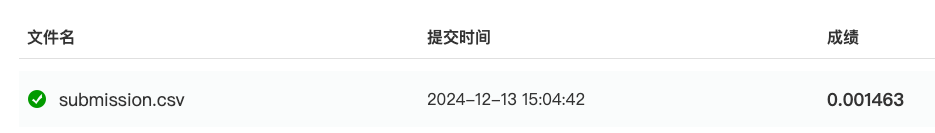


# 9. most popularity model

In [206]:
# rank the train items based on their popularity
train_items_popularity = train_interactions.item_ID.value_counts().reset_index()
train_items_popularity.columns = ['item_ID', 'popularity']
train_items_popularity.head(2), train_items_popularity.shape

(   item_ID  popularity
 0  1366929        2145
 1  1481490        1308,
 (99893, 2))

In [207]:
# in the test items, show the items ranking list based on their popularity
test_items_popularity = test_items_feature.merge(train_items_popularity, on='item_ID', how='left').sort_values(by='popularity', ascending=False)
test_items_popularity.head(20), test_items_popularity.shape

(      item_ID                                                                           item_name            brand channel        size gender class_map price_range style_50 color_50  unit_price  discount   sale_price  popularity
 584   1366929                                                                               西有灵犀卡           others  others           U     未知        帽子         2.0     运动潮流     黑色系列     1300.00  0.644202   837.462834      2145.0
 956   1557402                Alexia Sandra 白鹿/赵露思同款 帽子系列 女士纽扣装饰毛绒帽【731267/MZ8R9035白色 F】301261（虚库）    ALEXIA SANDRA      54           U      女        配饰         2.0       优雅     白色系列      658.55  0.968456   637.776621       710.0
 583   1535792                                                                            西有灵犀卡-季卡           others  others           U     未知        帽子         2.0     运动潮流     无色系列      500.00  1.000000   500.000000       608.0
 911   1457978                                   COACH蔻驰 女士秋冬经典标志CITY 托特包【5696IM

In [208]:
# extract the top 20 item_ID from the test_items_popularity, assigned them to the user_id in the test_users
top_20_popularity = test_items_popularity.head(20)
top_20_popularity

item_ID                                                                           item_name            brand channel        size gender class_map price_range style_50 color_50  unit_price  discount   sale_price  popularity
584   1366929                                                                               西有灵犀卡           others  others           U     未知        帽子         2.0     运动潮流     黑色系列     1300.00  0.644202   837.462834      2145.0
956   1557402                Alexia Sandra 白鹿/赵露思同款 帽子系列 女士纽扣装饰毛绒帽【731267/MZ8R9035白色 F】301261（虚库）    ALEXIA SANDRA      54           U      女        配饰         2.0       优雅     白色系列      658.55  0.968456   637.776621       710.0
583   1535792                                                                            西有灵犀卡-季卡           others  others           U     未知        帽子         2.0     运动潮流     无色系列      500.00  1.000000   500.000000       608.0
911   1457978                                   COACH蔻驰 女士秋冬经典标志CITY 托特包【5696IME74 浅棕色】300165（虚库）            COACH       2           U      女        箱包         2.0       奢华     米色系列     1890.00  0.363462   686.942308       540.0
77    1481486                      RECTO 棉质女士简约休闲领口拉链胸前logo日常连帽卫衣， 【SIGNATURE LOGO HOODIE GREY F】            RECTO      54           F      女        上装         2.0      实验性     灰色系列      888.63  0.663157   589.300953       481.0
548   1557403                Alexia Sandra 白鹿/赵露思同款 帽子系列 女士纽扣装饰毛绒帽【731267/MZ8R1000黑色 F】301261（虚库）    ALEXIA SANDRA  others           U      女        配饰         2.0       优雅     黑色系列      600.00  0.882353   529.411765       365.0
1045  1504242                      MOSCHINO 莫斯奇诺 21秋冬 男女款小熊刺绣羊毛围巾 【浅灰色 50124 M5293 014】300154（虚库）         MOSCHINO      54           U     男女        帽子         5.0     前卫个性     灰色系列      404.65  0.454663   183.979351       359.0
1177  1479597                      Dior迪奥全框圆形墨镜女款防强光太阳镜多色可选【DIORULTIMEF-LKSA9-53蓝灰反光镜片】300211（虚库）             DIOR      54           U      女        帽子         5.0       优雅     蓝色系列     1058.22  0.278479   294.691992       306.0
1041  1457976                                   COACH蔻驰 女士秋冬经典标志CITY 托特包【5696IMAA8 深棕色】300165（虚库）            COACH      54           U      女        箱包         2.0       奢华     棕色系列     1479.15  0.284452   420.747062       260.0
1768  1532258            Longchamp珑骧女士LE PLIAGE GREEN系列织物长柄可折叠手提单肩包饺子包【2605 919 小号森林绿色】300095（虚库）        LONGCHAMP  others           U      女        箱包         2.0       经典     绿色系列      750.00  0.681818   511.363636       239.0
899   1504243                      MOSCHINO 莫斯奇诺 21秋冬 男女款小熊刺绣羊毛围巾 【深灰色 50124 M5293 015】300154（虚库）         MOSCHINO      54           U     男女        帽子         5.0     前卫个性     灰色系列      432.35  0.485787   210.029801       229.0
965   1576126             Alexia Sandra 新年限定 撞色系列 女士四只兔子插肩长袖T恤 【770722/TZ3C0100 黑白色  S】301261（虚库）    ALEXIA SANDRA      54           S      女        上装         2.0       优雅     黑色系列      857.27  0.669742   574.149885       224.0
557   1503568                                                 Gucci 女士古驰双G双面织花围巾165904浅咖啡色 300099            GUCCI  others           U      女        帽子         5.0       奢华     棕色系列     2500.00  0.862069  2155.172414       216.0
1729  1530099                                            RECTO 2022春夏 女士 T恤【RCK215TS001 WHITE F】,            RECTO      54           F      女        上装         2.0      实验性     白色系列      295.57  0.493439   145.845784       214.0
1126  1578138  EMPORIO ARMANI 阿玛尼 男士棉质圆领短袖T恤衫（两件套）【黑色/白色 111267 2F722 10320 L码 175/96A】300154（虚库）   EMPORIO ARMANI      54  L码 175/96A      男        上装         4.0     高端时尚     黑色系列      332.31  0.639058   212.365262       209.0
1025  1475223                                   Sofitte/ 童趣经典玩偶 兔子短袖 男女同款【2020UP001930黑色 1】300199          SOFITTE      54           1     男女        上装         2.0     优雅简约     黑色系列      629.03  0.455819   286.723725       204.0
1010  1479596                      Dior迪奥全框圆形墨镜女款防强光太阳镜多色可选【DIORULTIMEF-AVBSQ-53金色反光镜片】300211（虚库）             DIO

In [317]:
# create another submission file that assigned the top 20 popular items to each user
submission_popularity = test_users.copy()
for i in range(1, 21):
    submission_popularity[f'item_{i}'] = top_20_popularity['item_ID'].values[i-1]
submission_popularity.head(2), submission_popularity.shape

(   user_id   item_1   item_2   item_3   item_4   item_5   item_6   item_7   item_8   item_9  item_10  item_11  item_12  item_13  item_14  item_15  item_16  item_17  item_18  item_19  item_20
 0        1  1366929  1557402  1535792  1457978  1481486  1557403  1504242  1479597  1457976  1532258  1504243  1576126  1503568  1530099  1578138  1475223  1479596  1542735  1507558  1576127
 1        2  1366929  1557402  1535792  1457978  1481486  1557403  1504242  1479597  1457976  1532258  1504243  1576126  1503568  1530099  1578138  1475223  1479596  1542735  1507558  1576127,
 (1333, 21))

In [319]:
# save to csv
submission_popularity.to_csv("submission_popularity.csv", index=False)


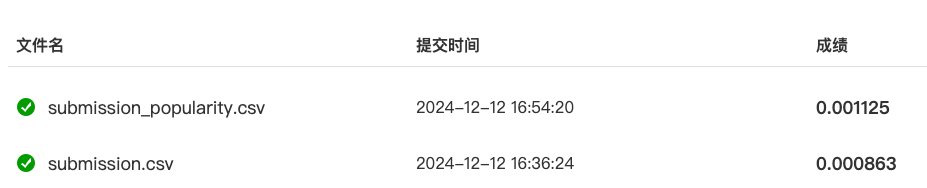

# 10. TFIDF transform item_name-Ligistic regression

In [65]:
train_data.head(2)

user_id  item_ID                                          item_name  \
0   209227  1595587        BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】   
1   243637  1639001  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】30136...   

      brand channel size gender class_map price_range style_50 color_50  \
0  BURBERRY  others    M      男        上装         1.0       经典    卡其色系列   
1    others       2    L      男        上装         2.0     运动潮流     灰色系列   

   unit_price  discount   sale_price  num_items_bought  avg_discount  \
0      2880.0  0.600000  1728.000000                 3      0.682828   
1       519.0  0.524242   272.081818                 2      0.524242   

   avg_sale_price          most_like_brand most_like_size most_like_class_map  \
0     1751.919192  AMI ALEXANDRE MATTIUSSI              M                  上装   
1      272.081818                   others              L                  上装   

  most_like_style_50 most_like_color_50  label  
0               高端时尚              卡其色系列      1  
1               运动潮流               灰色系列      1

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [67]:
train_items_feature = pd.read_csv("train_items_feature.csv")
test_items_feature = pd.read_csv("test_items_feature.csv")

In [34]:
train_items_feature.head(2), train_items_feature.shape

(   item_ID                                     item_name   brand channel size  \
 0  1001920                         Fendi女子皮制鞋12184-X3474   FENDI  others   39   
 1  1003191  【自营】BCBG-MAXAZRIA女士皮制手提书包 【特卖货品，缺货退款，延迟发货见谅】  others      15    U   
 
   gender class_map  price_range style_50 color_50  unit_price  discount  \
 0      女        鞋靴          5.0       奢华   others       299.0  0.059443   
 1      女        箱包          2.0       优雅     红色系列        89.0  0.032014   
 
    sale_price  
 0   17.773559  
 1    2.849281  ,
 (99893, 13))

In [68]:
item_names = train_items_feature['item_name']

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10, stop_words='english', ngram_range=(2, 4))

# Fit and transform the item_name column
tfidf_matrix = vectorizer.fit_transform(item_names)

# Convert the result to a DataFrame if needed
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names())

# Concatenate item_ID and TFIDF DataFrames
train_items_feature_tfidf = pd.concat([train_items_feature[['item_ID']].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [69]:
train_items_feature_tfidf.head(2), train_items_feature_tfidf.shape  

(   item_ID  189303 虚库  2022春夏 女士  2022秋冬 女士  300095 虚库  301353 虚库  \
 0  1001920        0.0        0.0        0.0        0.0        0.0   
 1  1003191        0.0        0.0        0.0        0.0        0.0   
 
    aquascutum 雅格狮丹  emporio armani  hugo boss  kenzo 高田贤三  maison kitsune  
 0              0.0             0.0        0.0         0.0             0.0  
 1              0.0             0.0        0.0         0.0             0.0  ,
 (99893, 11))

In [70]:
# transform the test_items_feature
item_names_test = test_items_feature['item_name']

# Fit and transform the item_name column
tfidf_matrix_test = vectorizer.transform(item_names_test)

# Convert the result to a DataFrame if needed
tfidf_df_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=vectorizer.get_feature_names())

# Concatenate item_ID and TFIDF DataFrames
test_items_feature_tfidf = pd.concat([test_items_feature[['item_ID']].reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)

test_items_feature_tfidf.head(2), test_items_feature_tfidf.shape

(   item_ID  189303 虚库  2022春夏 女士  2022秋冬 女士  300095 虚库  301353 虚库  \
 0  1657680        0.0        0.0        0.0        0.0        0.0   
 1  1525546        0.0        0.0        0.0        0.0        0.0   
 
    aquascutum 雅格狮丹  emporio armani  hugo boss  kenzo 高田贤三  maison kitsune  
 0              0.0             0.0        0.0         0.0             0.0  
 1              0.0             0.0        0.0         0.0             0.0  ,
 (11510, 11))

In [71]:
test_items_feature_tfidf.shape,  test_items_feature_tfidf.shape

((11510, 11), (11510, 11))

In [72]:
# add train_items_feature_tfidf to train_data by item_ID
train_data_tfidf = train_data.merge(train_items_feature_tfidf, on='item_ID', how='left')
train_data_tfidf.head(2), train_data_tfidf.shape

(   user_id  item_ID                                          item_name  \
 0   209227  1595587        BURBERRY/博柏利 2023春夏 男士 衬衫 【8020869 A7028 M】   
 1   243637  1639001  Tommy Hilfiger 男士长袖衬衫【78E5393-079-L 灰色 L】30136...   
 
       brand channel size gender class_map price_range style_50 color_50  \
 0  BURBERRY  others    M      男        上装         1.0       经典    卡其色系列   
 1    others       2    L      男        上装         2.0     运动潮流     灰色系列   
 
    unit_price  discount   sale_price  num_items_bought  avg_discount  \
 0      2880.0  0.600000  1728.000000                 3      0.682828   
 1       519.0  0.524242   272.081818                 2      0.524242   
 
    avg_sale_price          most_like_brand most_like_size most_like_class_map  \
 0     1751.919192  AMI ALEXANDRE MATTIUSSI              M                  上装   
 1      272.081818                   others              L                  上装   
 
   most_like_style_50 most_like_color_50  label  189303 虚库  2022春夏 女士  \
 

In [73]:
# check missing
train_data_tfidf.isnull().mean()*100 # no missing values

user_id                0.0
item_ID                0.0
item_name              0.0
brand                  0.0
channel                0.0
size                   0.0
gender                 0.0
class_map              0.0
price_range            0.0
style_50               0.0
color_50               0.0
unit_price             0.0
discount               0.0
sale_price             0.0
num_items_bought       0.0
avg_discount           0.0
avg_sale_price         0.0
most_like_brand        0.0
most_like_size         0.0
most_like_class_map    0.0
most_like_style_50     0.0
most_like_color_50     0.0
label                  0.0
189303 虚库              0.0
2022春夏 女士              0.0
2022秋冬 女士              0.0
300095 虚库              0.0
301353 虚库              0.0
aquascutum 雅格狮丹        0.0
emporio armani         0.0
hugo boss              0.0
kenzo 高田贤三             0.0
maison kitsune         0.0
dtype: float64

In [74]:
train_data_tfidf.dtypes

user_id                  int64
item_ID                  int64
item_name               object
brand                   object
channel                 object
size                    object
gender                  object
class_map               object
price_range             object
style_50                object
color_50                object
unit_price             float64
discount               float64
sale_price             float64
num_items_bought         int64
avg_discount           float64
avg_sale_price         float64
most_like_brand         object
most_like_size          object
most_like_class_map     object
most_like_style_50      object
most_like_color_50      object
label                    int64
189303 虚库              float64
2022春夏 女士              float64
2022秋冬 女士              float64
300095 虚库              float64
301353 虚库              float64
aquascutum 雅格狮丹        float64
emporio armani         float64
hugo boss              float64
kenzo 高田贤三             float64
maison k

In [ ]:
y_train = train_data_tfidf["label"]

features = list(train_data_tfidf.columns)

features.remove("label")
features.remove("user_id")
features.remove("item_ID")
features.remove("item_name")

# split the dataset as training and testing at 80% and 20%, keep ratios of positive and negative samples
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    train_data_tfidf[features], 
    y_train, 
    test_size=0.2, 
    random_state=42)

# set up pipeline for logistic regression, deal with numerical variables with standard scaler, and deal with categorical variables with one hot encoder

# numerical features
numerical_features = X_train_tfidf.select_dtypes(include=['int64', 'float64']).columns
# categorical features
categorical_features = X_train_tfidf.select_dtypes(include=['object']).columns

# pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# full pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# logistic regression model with data with tfidf
model_tfidf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, 
                                        random_state=42,
                                        class_weight='balanced',
                                      n_jobs=-1))
])

# fit the model
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# predict the test data
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)


# calculate the accuracy
accuracy_score(y_test_tfidf, y_pred_tfidf)

# calculate the confusion matrix
confusion_matrix(y_test_tfidf, y_pred_tfidf)

# calculate the precision, recall, f1 score
precision_score(y_test_tfidf, y_pred_tfidf), recall_score(y_test_tfidf, y_pred_tfidf), f1_score(y_test_tfidf, y_pred_tfidf)



/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.40412027377493515, 0.6747409632179978, 0.5054894798942654)

In [79]:
# calculate the classification report
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82    490637
           1       0.40      0.67      0.51    122859

    accuracy                           0.74    613496
   macro avg       0.65      0.71      0.66    613496
weighted avg       0.80      0.74      0.76    613496



In [91]:
# create the test item feature with tfidf
test_items_feature_tfidf = test_items_feature.merge(test_items_feature_tfidf, on='item_ID', how='left')
test_items_feature_tfidf.head()

item_ID                                          item_name  \
0  1657680  Alexia Sandra 牛仔系列 女士简约松紧腰牛仔长裤【477948NZ4K9605 ...   
1  1525546      CAMPER 女士经典黑色简约日常圆头针扣系带休闲凉鞋，【K200573-012 36】,   
2  1525194  JOSHUA'S 女士经典笑脸图案印花设计套头日常休闲圆领短袖T恤，【JS RTW 1003...   
3  1523948  NOTHING WRITTEN 女士纯色宽松休闲随性圆领短袖上衣，【NW22SP-1010 ...   
4  1534750  INSPIRE&amp;STORIES女士经典条纹长款连衣裙【IS2204-K009-JS0...   

             brand channel size gender class_map price_range style_50  \
0    ALEXIA SANDRA      54    S      女        裤子         2.0       优雅   
1           CAMPER      54   36      女        鞋靴         3.0      户外风   
2           others      54   XS      女        上装         3.0      街头风   
3           others      54    M      女        上装         2.0       前卫   
4  INSPIRE&STORIES      54    L      女        裙子         3.0       优雅   

  color_50  unit_price  discount   sale_price  189303 虚库  2022春夏 女士  \
0     蓝色系列      871.46  0.738525   643.595366        0.0        0.0   
1     黑色系列      635.34  0.635976   404.060977        0.0        0.0   
2     白色系列      400.26  0.588618   235.600099        0.0        0.0   
3     灰色系列      358.62  0.587902   210.833286        0.0        0.0   
4     条纹系列     1432.53  0.761984  1091.565000        0.0        0.0   

   2022秋冬 女士  300095 虚库  301353 虚库  aquascutum 雅格狮丹  emporio armani  \
0        0.0        0.0        0.0              0.0             0.0   
1        0.0        0.0        0.0              0.0             0.0   
2        0.0        0.0        0.0              0.0             0.0   
3        0.0        0.0        0.0              0.0             0.0   
4        0.0        0.0        0.0              0.0             0.0   

   hugo boss  kenzo 高田贤三  maison kitsune  
0        0.0         0.0             0.0  
1        0.0         0.0             0.0  
2        0.0         0.0             0.0  
3        0.0         0.0             0.0  
4        0.0         0.0             0.0

In [92]:
# get prediction for all users
results = []
for uid in test_users["user_id"]:
    result = get_top_K(uid, model_tfidf, test_user, test_items_feature_tfidf, features)
    result = [uid] + result
    results.append(result)

df = pd.DataFrame(results)

df.head()

0        1        2        3        4        5        6        7        8   \
0   1  1578138  1578137  1530099  1530106  1481486  1671030  1535792  1549257   
1   2  1657680  1655689  1589737  1601136  1672220  1549141  1688472  1685883   
2   4  1578138  1578137  1530099  1530106  1481486  1671030  1535792  1549257   
3  50  1578138  1578137  1530099  1530106  1481486  1671030  1535792  1549257   
4  65  1578138  1578137  1530099  1530106  1481486  1671030  1535792  1549257   

        9        10       11       12       13       14       15       16  \
0  1657278  1657279  1671033  1671031  1637483  1637460  1671032  1671034   
1  1546394  1673930  1671104  1671105  1640004  1627364  1676191  1674361   
2  1657278  1657279  1671033  1671031  1637483  1637460  1671032  1671034   
3  1657278  1657279  1671033  1671031  1637483  1637460  1671032  1671034   
4  1657278  1657279  1671033  1671031  1637483  1637460  1671032  1671034   

        17       18       19       20  
0  1637484  1637489  1638817  1637481  
1  1678861  1681889  1684832  1537268  
2  1637484  1637489  1638817  1637481  
3  1637484  1637489  1638817  1637481  
4  1637484  1637489  1638817  1637481

In [94]:
cols = ["user_id"]
for i in range(20):
    cols.append("item_{}".format(i + 1))
df.columns = cols
df.head(2)

user_id   item_1   item_2   item_3   item_4   item_5   item_6   item_7  \
0        1  1578138  1578137  1530099  1530106  1481486  1671030  1535792   
1        2  1657680  1655689  1589737  1601136  1672220  1549141  1688472   

    item_8   item_9  item_10  item_11  item_12  item_13  item_14  item_15  \
0  1549257  1657278  1657279  1671033  1671031  1637483  1637460  1671032   
1  1685883  1546394  1673930  1671104  1671105  1640004  1627364  1676191   

   item_16  item_17  item_18  item_19  item_20  
0  1671034  1637484  1637489  1638817  1637481  
1  1674361  1678861  1681889  1684832  1537268

In [95]:
# save to csv file for submission
df.to_csv("submission_tfidf.csv", index=False)

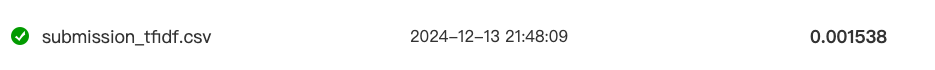

# 11. Matrix Factorization 

In [3]:
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.data import Dataset

In [5]:
# load train and test users data
train_users = pd.read_csv("train_users.csv")
test_users = pd.read_csv("test_users.csv")

# load train and test items data
train_items_feature = pd.read_csv("train_items_feature.csv")
test_items_feature = pd.read_csv("test_items_feature.csv")

# load interactions
train_interactions_filter = pd.read_csv("train_interactions_filter.csv")

In [6]:
# combined train_items_feature and test_items_feature, they have some overlaps
items = pd.concat([train_items_feature, test_items_feature]).reset_index(drop=True)
# drop duplicates
items = items.drop_duplicates(subset=['item_ID']).reset_index(drop=True)

items.shape, train_items_feature.shape[0]+test_items_feature.shape[0]

((106411, 13), 111403)

In [51]:
# load user feature
user_profile = pd.read_csv("user_profile.csv")
user_profile.head(2)

user_id  num_items_bought  num_unique_items_bought  \
0        1                 5                        5   
1        2               986                      916   

   num_unique_brands_bought  num_unique_channels_bought  \
0                         3                           2   
1                        72                           4   

   num_unique_sizes_bought  num_unique_class_map_bought  \
0                        3                            3   
1                       57                            8   

   num_unique_price_range_bought  num_unique_style_50_bought  \
0                              1                           4   
1                              5                          28   

   num_unique_color_50_bought most_like_brand most_like_size  \
0                           5          others              M   
1                          25          others              S   

  most_like_class_map most_like_style_50 most_like_color_50  avg_discount  \
0                  上装                 优雅              深蓝色系列      0.643710   
1                  上装                 优雅               黑色系列      0.325933   

   avg_sale_price  
0      835.417766  
1      421.552712

In [58]:
items.columns

Index(['item_ID', 'item_name', 'brand', 'channel', 'size', 'gender',
       'class_map', 'price_range', 'style_50', 'color_50', 'unit_price',
       'discount', 'sale_price'],
      dtype='object')

In [59]:
# Initialize the LightFM Dataset object
dataset = Dataset()

# Fit the dataset with all user IDs and item IDs
dataset.fit(
    users=train_interactions_filter['user_id'].unique(),
    items=items['item_ID'].unique(),  # Use all items from train_items
    user_features=user_profile[['num_items_bought', 'num_unique_items_bought',
       'num_unique_brands_bought', 'num_unique_channels_bought',
       'num_unique_sizes_bought', 'num_unique_class_map_bought',
       'num_unique_price_range_bought', 'num_unique_style_50_bought',
       'num_unique_color_50_bought', 'most_like_brand', 'most_like_size',
       'most_like_class_map', 'most_like_style_50', 'most_like_color_50',
       'avg_discount', 'avg_sale_price']].stack().unique(),
    item_features=items[['brand', 'channel', 'size', 'gender',
       'class_map', 'price_range', 'style_50', 'color_50', 'unit_price',
       'discount', 'sale_price']].stack().unique()
)

# Build the user features matrix
user_features_matrix = dataset.build_user_features(
    [(row['user_id'], row.drop(['user_id']).values.tolist())
     for _, row in user_profile.iterrows()]
)

# Build interaction matrix
(interactions, _) = dataset.build_interactions(
    [(row['user_id'], row['item_ID']) for _, row in train_interactions_filter.iterrows()]
)

# Build item features matrix
item_features = dataset.build_item_features(
    [(row['item_ID'], row.drop(['item_ID', 'item_name']).values.tolist())
     for _, row in items.iterrows()]
)



In [67]:
# Initialize the LightFM model
model_MF = LightFM(loss='warp')  # WARP loss for ranking optimization

# Train the model
model_MF.fit(
    interactions,
    item_features=item_features,
    user_features=user_features_matrix,
    epochs=100,  # Number of epochs
    num_threads=4,  # Number of threads
    verbose=True  # Show logs
)



Epoch: 100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


In [68]:
sample_user_id = 270497

# Map test item IDs to indices in the item_features matrix
test_item_indices = items[items['item_ID'].isin(test_items_feature['item_ID'])].index.tolist()

# Predict scores for test items only
scores = model_MF.predict(sample_user_id, test_item_indices, item_features=item_features, num_threads=4)

# Get the indices of the top n_rec items from test items
top_items_test = np.argsort(-scores)[:n_rec]

# Map the indices back to item IDs
test_item_recommendations = [test_items_feature.iloc[i]['item_ID'] for i in top_items_test]

# Retrieve item_ID of recommended test items
test_item_recommendations_ID = test_items_feature[test_items_feature['item_ID'].isin(test_item_recommendations)]['item_ID']

# Display recommendations
test_item_recommendations_ID



66       1672157
207      1590646
239      1549375
250      1680012
251      1678213
414      1535958
492      1671912
642      1666426
646      1518211
647      1553705
1590     1660635
2555     1683924
2804     1583374
2817     1680425
3226     1677997
3510     1546440
3568     1645362
10868    1672694
11151    1525783
11328    1546281
Name: item_ID, dtype: int64

In [69]:

def get_test_item_recommendations(model, sample_user_id, test_items_feature, items, item_features, n_rec=20):
    """
    Generate recommendations for a sample user from test items.

    Parameters:
    - model: The trained LightFM model.
    - sample_user_id: The ID of the sample user.
    - test_items_feature: DataFrame containing features of test items.
    - items: DataFrame containing all items.
    - item_features: Item features matrix.
    - n_rec: Number of items to recommend (default is 20).

    Returns:
    - List of recommended item IDs.
    """
    # Map test item IDs to indices in the item_features matrix
    test_item_ids = test_items_feature['item_ID'].values
    test_item_indices = items[items['item_ID'].isin(test_item_ids)].index.tolist()

    # Predict scores for test items only
    scores = model.predict(sample_user_id, test_item_indices, item_features=item_features, num_threads=4)

    # Get the indices of the top n_rec items from test items
    top_items_test = np.argsort(-scores)[:n_rec]

    # Map the indices back to item IDs
    test_item_recommendations = [test_item_ids[i] for i in top_items_test]

    return test_item_recommendations



In [70]:
get_test_item_recommendations(model_MF, 270496, test_items_feature, items, item_features, n_rec=20)

[1479114,
 1617535,
 1672157,
 1590646,
 1522249,
 1457988,
 1546379,
 1549375,
 1519826,
 1553705,
 1680073,
 1583429,
 1671869,
 1674797,
 1633354,
 1525783,
 1540609,
 1518211,
 1679995,
 1684741]

In [71]:
# Generate recommendations for all users in test_users
results = []
for uid in test_users['user_id']:
    result = get_test_item_recommendations(model_MF, uid, test_items_feature, items, item_features, n_rec)
    result = [uid] + result
    print(result)
    results.append(result)



[1, 1650005, 1679392, 1673683, 1676204, 1659693, 1637132, 1608497, 1685602, 1497649, 1530971, 1629200, 1504250, 1662432, 1660032, 1618120, 1479515, 1673816, 1568876, 1672047, 1666521]
[2, 1590646, 1479114, 1502384, 1648467, 1685846, 1617535, 1671912, 1551497, 1529088, 1674383, 1676999, 1673115, 1521107, 1599836, 1633354, 1549382, 1526712, 1457988, 1677742, 1604973]
[4, 1522249, 1519826, 1583429, 1671912, 1617535, 1660177, 1678213, 1518408, 1546379, 1617516, 1633354, 1608497, 1680073, 1479114, 1629751, 1680012, 1648467, 1540609, 1520839, 1549382]
[50, 1608930, 1567841, 1650005, 1637132, 1496889, 1608234, 1479113, 1637552, 1686951, 1571693, 1683859, 1674047, 1662461, 1477921, 1546118, 1618040, 1630357, 1666762, 1568876, 1673683]
[65, 1654977, 1665909, 1544660, 1543494, 1576685, 1605671, 1654979, 1672300, 1662455, 1671809, 1605554, 1544549, 1605684, 1683366, 1679066, 1635068, 1588187, 1605670, 1683001, 1641006]
[238, 1666972, 1682276, 1587044, 1631325, 1548733, 1673319, 1577505, 1662121, 

In [72]:
# Create a DataFrame with the results
df = pd.DataFrame(results)

# Rename columns
cols = ["user_id"]
for i in range(20):
    cols.append("item_{}".format(i + 1))

df.columns = cols
df.head(2)

user_id   item_1   item_2   item_3   item_4   item_5   item_6   item_7  \
0        1  1650005  1679392  1673683  1676204  1659693  1637132  1608497   
1        2  1590646  1479114  1502384  1648467  1685846  1617535  1671912   

    item_8   item_9  item_10  item_11  item_12  item_13  item_14  item_15  \
0  1685602  1497649  1530971  1629200  1504250  1662432  1660032  1618120   
1  1551497  1529088  1674383  1676999  1673115  1521107  1599836  1633354   

   item_16  item_17  item_18  item_19  item_20  
0  1479515  1673816  1568876  1672047  1666521  
1  1549382  1526712  1457988  1677742  1604973

In [73]:
# save to csv file for submission
df.to_csv("submission_MF.csv", index=False)

The results is even worse than the all above models.

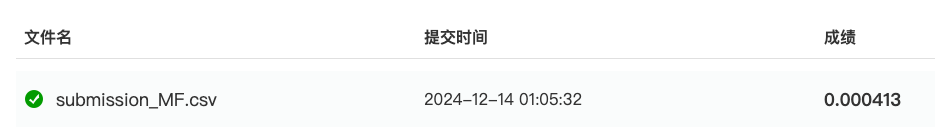